# Reconocimiento de Actividades Físicas mediante Aprendizaje Automático
## Dataset PAMAP2

Este notebook implementa el proceso KDD completo para clasificar actividades físicas usando datos sensoriales del dataset PAMAP2.

## 1. Importación de Bibliotecas

In [3]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Algoritmos de clasificación
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")

✓ Bibliotecas importadas correctamente


## 2. Carga y Exploración del Dataset PAMAP2

In [4]:
# Definir nombres de las columnas según la documentación del PAMAP2
column_names = [
    'timestamp', 'activityID', 'heart_rate',
    # IMU mano
    'hand_temp', 'hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z',
    'hand_acc_6g_x', 'hand_acc_6g_y', 'hand_acc_6g_z',
    'hand_gyro_x', 'hand_gyro_y', 'hand_gyro_z',
    'hand_mag_x', 'hand_mag_y', 'hand_mag_z',
    'hand_orient_1', 'hand_orient_2', 'hand_orient_3', 'hand_orient_4',
    # IMU pecho
    'chest_temp', 'chest_acc_16g_x', 'chest_acc_16g_y', 'chest_acc_16g_z',
    'chest_acc_6g_x', 'chest_acc_6g_y', 'chest_acc_6g_z',
    'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z',
    'chest_mag_x', 'chest_mag_y', 'chest_mag_z',
    'chest_orient_1', 'chest_orient_2', 'chest_orient_3', 'chest_orient_4',
    # IMU tobillo
    'ankle_temp', 'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z',
    'ankle_acc_6g_x', 'ankle_acc_6g_y', 'ankle_acc_6g_z',
    'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z',
    'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
    'ankle_orient_1', 'ankle_orient_2', 'ankle_orient_3', 'ankle_orient_4'
]

# Diccionario de actividades
activity_labels = {
    1: 'acostado',
    2: 'sentado',
    3: 'de pie',
    4: 'caminando',
    5: 'corriendo',
    6: 'ciclismo',
    7: 'caminata nordica',
    9: 'viendo TV',
    10: 'computadora',
    11: 'conduciendo',
    12: 'subir escaleras',
    13: 'bajar escaleras',
    16: 'aspirando',
    17: 'planchando',
    18: 'plegando ropa',
    19: 'limpiando',
    20: 'jugando futbol',
    24: 'saltando cuerda'
}

print("✓ Estructura del dataset definida")

✓ Estructura del dataset definida


In [5]:
# Cargar archivos del dataset
# El dataset PAMAP2 tiene archivos individuales por participante

data_path = Path('data/pamap2+physical+activity+monitoring/PAMAP2_Dataset/Protocol/')

# Lista para almacenar todos los datos
all_data = []

# Intentar cargar archivos de los sujetos (subject101.dat a subject109.dat)
subject_files = sorted(data_path.glob('subject10*.dat'))

if len(subject_files) == 0:
    print("⚠ No se encontraron archivos. Verificando ruta...")
    print(f"   Buscando en: {data_path.absolute()}")
    if data_path.exists():
        print(f"   Directorio existe. Archivos disponibles:")
        for f in data_path.glob('*.dat'):
            print(f"      - {f.name}")
    else:
        print("   ❌ El directorio no existe.")
else:
    for file in subject_files:
        print(f"Cargando {file.name}...")
        df_temp = pd.read_csv(file, sep=' ', header=None, names=column_names)
        all_data.append(df_temp)
    
    # Combinar todos los datos
    df = pd.concat(all_data, ignore_index=True)
    
    print(f"\n✓ Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")
    print(f"✓ Participantes cargados: {len(subject_files)}")

Cargando subject101.dat...
Cargando subject102.dat...
Cargando subject103.dat...
Cargando subject104.dat...
Cargando subject105.dat...
Cargando subject106.dat...
Cargando subject107.dat...
Cargando subject108.dat...
Cargando subject109.dat...

✓ Dataset cargado: 2872533 registros, 54 columnas
✓ Participantes cargados: 9


In [6]:
# Exploración inicial del dataset
if 'df' in locals():
    print("=== Información del Dataset ===")
    print(df.info())
    print("\n=== Primeras filas ===")
    print(df.head())
    print("\n=== Estadísticas descriptivas ===")
    print(df.describe())

=== Información del Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872533 entries, 0 to 2872532
Data columns (total 54 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        float64
 1   activityID       int64  
 2   heart_rate       float64
 3   hand_temp        float64
 4   hand_acc_16g_x   float64
 5   hand_acc_16g_y   float64
 6   hand_acc_16g_z   float64
 7   hand_acc_6g_x    float64
 8   hand_acc_6g_y    float64
 9   hand_acc_6g_z    float64
 10  hand_gyro_x      float64
 11  hand_gyro_y      float64
 12  hand_gyro_z      float64
 13  hand_mag_x       float64
 14  hand_mag_y       float64
 15  hand_mag_z       float64
 16  hand_orient_1    float64
 17  hand_orient_2    float64
 18  hand_orient_3    float64
 19  hand_orient_4    float64
 20  chest_temp       float64
 21  chest_acc_16g_x  float64
 22  chest_acc_16g_y  float64
 23  chest_acc_16g_z  float64
 24  chest_acc_6g_x   float64
 25  chest_acc_6g_y   float64
 26  chest_acc_

=== Distribución de Actividades ===
ID  0 - Desconocida (0)     :  929661 registros (32.36%)
ID  1 - acostado            :  192523 registros ( 6.70%)
ID  2 - sentado             :  185188 registros ( 6.45%)
ID  3 - de pie              :  189931 registros ( 6.61%)
ID  4 - caminando           :  238761 registros ( 8.31%)
ID  5 - corriendo           :   98199 registros ( 3.42%)
ID  6 - ciclismo            :  164600 registros ( 5.73%)
ID  7 - caminata nordica    :  188107 registros ( 6.55%)
ID 12 - subir escaleras     :  117216 registros ( 4.08%)
ID 13 - bajar escaleras     :  104944 registros ( 3.65%)
ID 16 - aspirando           :  175353 registros ( 6.10%)
ID 17 - planchando          :  238690 registros ( 8.31%)
ID 24 - saltando cuerda     :   49360 registros ( 1.72%)


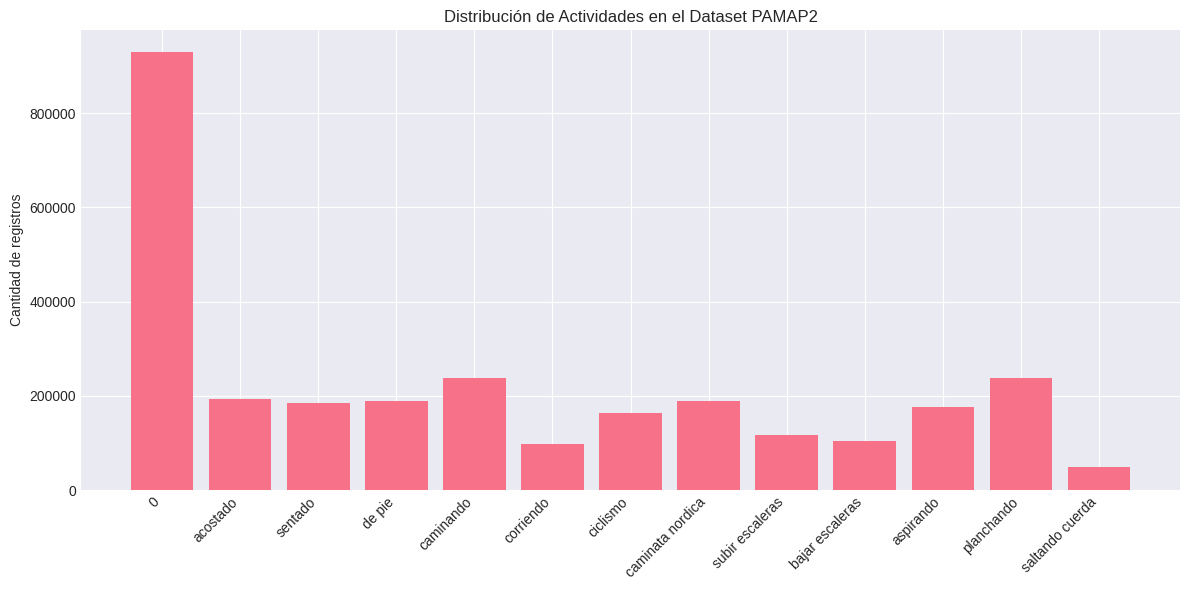

In [7]:
# Análisis de actividades
if 'df' in locals():
    print("=== Distribución de Actividades ===")
    activity_counts = df['activityID'].value_counts().sort_index()
    
    for act_id, count in activity_counts.items():
        label = activity_labels.get(int(act_id), f'Desconocida ({int(act_id)})')
        print(f"ID {int(act_id):2d} - {label:20s}: {count:7d} registros ({count/len(df)*100:5.2f}%)")
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = [activity_labels.get(int(x), str(x)) for x in activity_counts.index]
    ax.bar(range(len(activity_counts)), activity_counts.values)
    ax.set_xticks(range(len(activity_counts)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Cantidad de registros')
    ax.set_title('Distribución de Actividades en el Dataset PAMAP2')
    plt.tight_layout()
    plt.show()

## 3. Preprocesamiento de Datos

In [8]:
if 'df' in locals():
    # 1. Eliminar actividades transitorias (ID 0)
    print("=== Limpieza de Datos ===")
    print(f"Registros originales: {len(df)}")
    df_clean = df[df['activityID'] != 0].copy()
    print(f"Registros después de eliminar transiciones (ID=0): {len(df_clean)}")
    
    # 2. Análisis de valores perdidos
    print("\n=== Valores Perdidos ===")
    missing = df_clean.isnull().sum()
    missing_percent = (missing / len(df_clean)) * 100
    missing_df = pd.DataFrame({
        'Columna': missing.index,
        'Valores Perdidos': missing.values,
        'Porcentaje': missing_percent.values
    })
    print(missing_df[missing_df['Valores Perdidos'] > 0].sort_values('Valores Perdidos', ascending=False))
    
    # 3. ELIMINAR heart_rate POR 90.87% DE VALORES PERDIDOS
    print("\n=== Eliminación de heart_rate ===")
    print(f"✓ heart_rate tiene {missing_df.loc[missing_df['Columna'] == 'heart_rate', 'Porcentaje'].values[0]:.2f}% de valores perdidos")
    print("✓ Se elimina heart_rate por alta tasa de missingness y riesgo de distorsión fisiológica")
    
    # 4. Eliminar columna timestamp (no es una característica predictiva)
    df_clean = df_clean.drop(['timestamp', 'heart_rate'], axis=1)
    print(f"\n✓ Columnas eliminadas: 'timestamp', 'heart_rate'")
    print(f"✓ Dataset limpio: {df_clean.shape[0]} registros, {df_clean.shape[1]} columnas")
    print(f"✓ Características restantes: {df_clean.shape[1] - 1} (excluyendo activityID)")

=== Limpieza de Datos ===
Registros originales: 2872533
Registros después de eliminar transiciones (ID=0): 1942872

=== Valores Perdidos ===
            Columna  Valores Perdidos  Porcentaje
2        heart_rate           1765464   90.868776
3         hand_temp             11124    0.572554
4    hand_acc_16g_x             11124    0.572554
5    hand_acc_16g_y             11124    0.572554
6    hand_acc_16g_z             11124    0.572554
7     hand_acc_6g_x             11124    0.572554
8     hand_acc_6g_y             11124    0.572554
9     hand_acc_6g_z             11124    0.572554
10      hand_gyro_x             11124    0.572554
11      hand_gyro_y             11124    0.572554
12      hand_gyro_z             11124    0.572554
13       hand_mag_x             11124    0.572554
14       hand_mag_y             11124    0.572554
15       hand_mag_z             11124    0.572554
16    hand_orient_1             11124    0.572554
17    hand_orient_2             11124    0.572554
18    han

In [9]:
if 'df_clean' in locals():
    # 4. Manejo de valores perdidos: imputación con la mediana
    print("=== Imputación de Valores Perdidos ===")
    
    # Separar características y etiquetas
    X = df_clean.drop('activityID', axis=1)
    y = df_clean['activityID']
    
    # Imputar valores perdidos con la mediana
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    print(f"✓ Valores perdidos imputados con la mediana")
    print(f"✓ Características: {X_imputed.shape[1]}")
    print(f"✓ Registros: {X_imputed.shape[0]}")
    
    # Verificar que no quedan valores perdidos
    remaining_missing = X_imputed.isnull().sum().sum()
    print(f"✓ Valores perdidos restantes: {remaining_missing}")

=== Imputación de Valores Perdidos ===
✓ Valores perdidos imputados con la mediana
✓ Características: 51
✓ Registros: 1942872
✓ Valores perdidos restantes: 0


In [10]:
if 'X_imputed' in locals():
    # 5. División del dataset en entrenamiento y prueba
    print("=== División del Dataset ===")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    print(f"✓ Conjunto de entrenamiento: {X_train.shape[0]} registros")
    print(f"✓ Conjunto de prueba: {X_test.shape[0]} registros")
    print(f"✓ Proporción: 80% / 20%")
    
    # Verificar distribución de clases
    print("\n=== Distribución en Entrenamiento ===")
    print(y_train.value_counts().sort_index())
    print("\n=== Distribución en Prueba ===")
    print(y_test.value_counts().sort_index())

=== División del Dataset ===
✓ Conjunto de entrenamiento: 1554297 registros
✓ Conjunto de prueba: 388575 registros
✓ Proporción: 80% / 20%

=== Distribución en Entrenamiento ===
activityID
1     154018
2     148150
3     151945
4     191009
5      78559
6     131680
7     150486
12     93773
13     83955
16    140282
17    190952
24     39488
Name: count, dtype: int64

=== Distribución en Prueba ===
activityID
1     38505
2     37038
3     37986
4     47752
5     19640
6     32920
7     37621
12    23443
13    20989
16    35071
17    47738
24     9872
Name: count, dtype: int64


In [11]:
if 'X_train' in locals():
    # 6. Normalización de características
    print("=== Normalización de Características ===")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"✓ Características normalizadas (media=0, desv.std=1)")
    print(f"✓ Media del conjunto de entrenamiento: {X_train_scaled.mean():.6f}")
    print(f"✓ Desviación estándar del conjunto de entrenamiento: {X_train_scaled.std():.6f}")
    
    # Convertir de vuelta a DataFrame para facilitar el análisis
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print(f"\n✓ Preprocesamiento completado")

=== Normalización de Características ===
✓ Características normalizadas (media=0, desv.std=1)
✓ Media del conjunto de entrenamiento: 0.000000
✓ Desviación estándar del conjunto de entrenamiento: 1.000000

✓ Preprocesamiento completado


## 4. Algoritmo 1: K-Nearest Neighbors (KNN)

### 4.1. Descripción del Algoritmo

**K-Nearest Neighbors (K-NN)** es un algoritmo de aprendizaje supervisado no paramétrico que clasifica una nueva instancia según la clase mayoritaria entre sus k vecinos más cercanos en el espacio de características. La cercanía se mide con métricas como distancia euclidiana.

**Ventajas:**
- Simple de entender e implementar
- No requiere fase de entrenamiento explícita (aprendizaje perezoso)
- Se adapta fácilmente a nuevos datos
- Útil para problemas de clasificación y regresión

**Desventajas:**
- Costoso computacionalmente en predicción (alto costo en memoria y tiempo)
- Sensible a características irrelevantes o de escala diferente
- Rendimiento disminuye en espacios de alta dimensión (maldición de la dimensionalidad)
- La elección de k y la métrica de distancia es crítica

### 4.2. Búsqueda del Mejor Valor de K

=== Búsqueda del Mejor Valor de K ===
(Usando submuestreo para mayor velocidad)

Entrenando con 10000 muestras (total disponible: 1554297)

Evaluando K=3... Train: 0.9474, Test: 0.8941
Evaluando K=7... Train: 0.9035, Test: 0.8654
Evaluando K=11... Train: 0.8749, Test: 0.8448


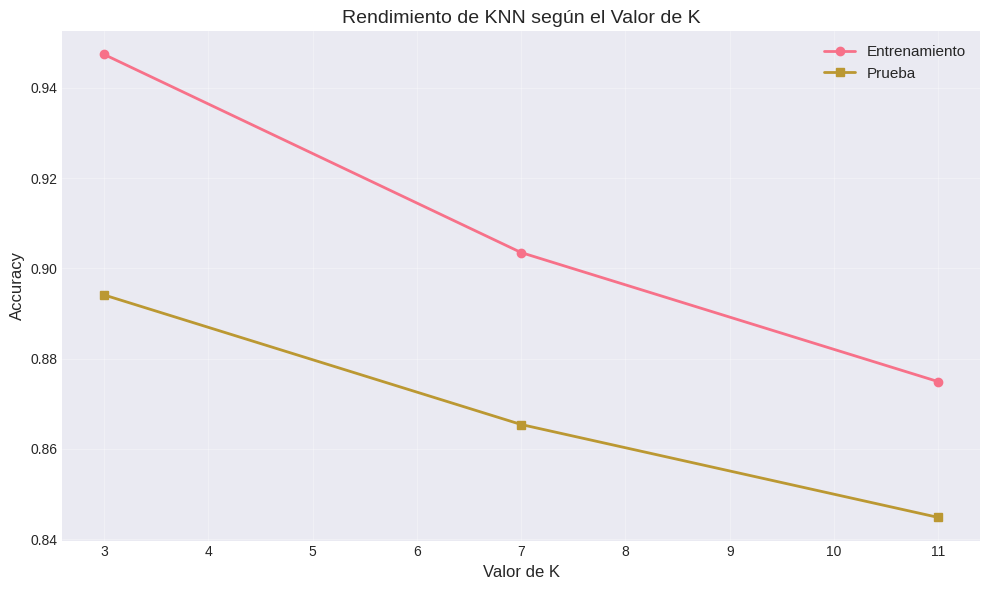


✓ Mejor valor de K: 3
✓ Mejor accuracy en prueba: 0.8941

ℹ Nota: Usando OPCIÓN 1 (rápido). Para búsqueda exhaustiva, descomentar OPCIÓN 2


In [12]:
if 'X_train_scaled' in locals():
    print("=== Búsqueda del Mejor Valor de K ===")
    
    # OPCIÓN 1: RÁPIDO - Con submuestreo (activo para presentación)
    print("(Usando submuestreo para mayor velocidad)\n")
    k_values = [3, 7, 11]  # Valores clave
    train_scores = []
    test_scores = []
    
    sample_size = min(10000, len(X_train_scaled))  # Máximo 10k muestras
    X_train_sample = X_train_scaled.sample(n=sample_size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
    
    print(f"Entrenando con {sample_size} muestras (total disponible: {len(X_train_scaled)})\n")
    
    for k in k_values:
        print(f"Evaluando K={k}...", end=' ')
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_train_sample, y_train_sample)
        train_score = knn.score(X_train_sample, y_train_sample)
        test_score = knn.score(X_test_scaled, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)
        print(f"Train: {train_score:.4f}, Test: {test_score:.4f}")
    
    # OPCIÓN 2: COMPLETO - Sin submuestreo (comentado, descomentar para evaluación final)
    # print("(Usando dataset completo para búsqueda exhaustiva)\n")
    # k_values = [3, 5, 7, 9, 11]  # Más valores de K
    # train_scores = []
    # test_scores = []
    # 
    # for k in k_values:
    #     print(f"Evaluando K={k}...", end=' ')
    #     knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    #     knn.fit(X_train_scaled, y_train)
    #     train_score = knn.score(X_train_scaled, y_train)
    #     test_score = knn.score(X_test_scaled, y_test)
    #     train_scores.append(train_score)
    #     test_scores.append(test_score)
    #     print(f"Train: {train_score:.4f}, Test: {test_score:.4f}")
    
    # Visualizar resultados
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(k_values, train_scores, marker='o', label='Entrenamiento', linewidth=2)
    ax.plot(k_values, test_scores, marker='s', label='Prueba', linewidth=2)
    ax.set_xlabel('Valor de K', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Rendimiento de KNN según el Valor de K', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Identificar el mejor K
    best_k_idx = np.argmax(test_scores)
    best_k = k_values[best_k_idx]
    best_score = test_scores[best_k_idx]
    
    print(f"\n✓ Mejor valor de K: {best_k}")
    print(f"✓ Mejor accuracy en prueba: {best_score:.4f}")
    print(f"\nℹ Nota: Usando OPCIÓN 1 (rápido). Para búsqueda exhaustiva, descomentar OPCIÓN 2")

### 4.3. Entrenamiento del Modelo KNN Óptimo

In [13]:
if 'best_k' in locals():
    print("=== Entrenamiento del Modelo KNN Final ===")
    
    # ========================================================================
    # OPCIÓN 1: RÁPIDO - Subconjunto de 50k para no explotar tiempo/memoria
    # ========================================================================
    print("(Usando subconjunto de 50,000 muestras para mayor velocidad)\n")
    
    train_subset_size = min(50000, len(X_train_scaled))
    X_train_subset = X_train_scaled.sample(n=train_subset_size, random_state=42)
    y_train_subset = y_train.loc[X_train_subset.index]
    
    print(f"Entrenando con {train_subset_size} muestras (de {len(X_train_scaled)} disponibles)")
    
    knn_final = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
    print(f"Entrenando KNN con K={best_k}...", end=' ')
    knn_final.fit(X_train_subset, y_train_subset)
    print("✓")
    
    print(f"✓ Modelo KNN entrenado con K={best_k}")
    print(f"✓ Características utilizadas: {X_train_subset.shape[1]}")
    print(f"✓ Muestras de entrenamiento: {X_train_subset.shape[0]}")
    
    # ========================================================================
    # OPCIÓN 2: COMPLETO - Dataset completo para resultados finales (comentada)
    # ========================================================================
    # print("(Usando conjunto completo de entrenamiento)\n")
    # 
    # knn_final = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
    # print(f"Entrenando KNN con K={best_k} en dataset completo...", end=' ')
    # knn_final.fit(X_train_scaled, y_train)
    # print("✓")
    # 
    # print(f"✓ Modelo KNN entrenado con K={best_k}")
    # print(f"✓ Características utilizadas: {X_train_scaled.shape[1]}")
    # print(f"✓ Muestras de entrenamiento: {X_train_scaled.shape[0]}")
    
    # ========================================================================
    # Predicciones
    # ========================================================================
    print(f"\nRealizando predicciones en conjunto de prueba...", end=' ')
    y_test_pred = knn_final.predict(X_test_scaled)
    print("✓")
    
    # Predicciones en entrenamiento para evaluar overfitting
    print(f"Realizando predicciones en conjunto de entrenamiento...", end=' ')
    y_train_pred = knn_final.predict(X_train_subset)
    # y_train_pred = knn_final.predict(X_train_scaled)
    print("✓")
    
    print(f"\n✓ Predicciones completadas")
    print(f"ℹ Nota: Usando OPCIÓN 1 (subconjunto 50k). Para resultados finales, descomentar OPCIÓN 2")

=== Entrenamiento del Modelo KNN Final ===
(Usando subconjunto para demostración rápida)

Entrenando con 20000 muestras (de 1554297 disponibles)
Entrenando KNN con K=3... ✓
✓ Modelo KNN entrenado con K=3
✓ Características utilizadas: 51
✓ Muestras de entrenamiento: 20000

Realizando predicciones en conjunto de prueba... ✓
Realizando predicciones en conjunto de entrenamiento... ✓

✓ Predicciones completadas
ℹ Nota: Usando OPCIÓN 1 (rápido). Para resultados finales, descomentar OPCIÓN 2


### 4.4. Evaluación del Modelo KNN

In [48]:
if 'y_test_pred' in locals():
    print("=== Métricas de Evaluación - KNN ===\n")
    
    # Calcular métricas en TEST
    knn_accuracy = accuracy_score(y_test, y_test_pred)
    knn_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    knn_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    knn_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    print("📊 Conjunto de PRUEBA:")
    print(f"   Accuracy:  {knn_accuracy:.4f}")
    print(f"   Precision: {knn_precision:.4f}")
    print(f"   Recall:    {knn_recall:.4f}")
    print(f"   F1-Score:  {knn_f1:.4f}")
    
    # Calcular métricas en TRAIN (si existen las predicciones)
    if 'y_train_pred' in locals() and 'y_train_subset' in locals():
        accuracy_train = accuracy_score(y_train_subset, y_train_pred)
        precision_train = precision_score(y_train_subset, y_train_pred, average='weighted', zero_division=0)
        recall_train = recall_score(y_train_subset, y_train_pred, average='weighted', zero_division=0)
        f1_train = f1_score(y_train_subset, y_train_pred, average='weighted', zero_division=0)
        
        print("\n📊 Conjunto de ENTRENAMIENTO:")
        print(f"   Accuracy:  {accuracy_train:.4f}")
        print(f"   Precision: {precision_train:.4f}")
        print(f"   Recall:    {recall_train:.4f}")
        print(f"   F1-Score:  {f1_train:.4f}")
        
        # Análisis de overfitting
        diff_accuracy = accuracy_train - knn_accuracy
        print(f"\n🔍 ANÁLISIS DE GENERALIZACIÓN:")
        print(f"   Diferencia Accuracy: {diff_accuracy:.4f} ({diff_accuracy*100:.2f}%)")
        
        if diff_accuracy < 0.05:
            print("   ✅ Excelente generalización (diferencia < 5%)")
        elif diff_accuracy < 0.10:
            print("   ⚠️  Generalización aceptable (diferencia < 10%)")
        else:
            print("   ⚠️  Posible overfitting (diferencia >= 10%)")
    
    # Reporte de clasificación detallado
    print("\n=== Reporte de Clasificación por Actividad (TEST) ===\n")
    print(classification_report(
        y_test, y_test_pred,
        target_names=[activity_labels.get(int(x), str(x)) for x in sorted(y_test.unique())],
        zero_division=0
    ))

=== Métricas de Evaluación - KNN ===

📊 Conjunto de PRUEBA:
   Accuracy:  0.9308
   Precision: 0.9322
   Recall:    0.9308
   F1-Score:  0.9297

📊 Conjunto de ENTRENAMIENTO:
   Accuracy:  0.9684
   Precision: 0.9689
   Recall:    0.9684
   F1-Score:  0.9682

🔍 ANÁLISIS DE GENERALIZACIÓN:
   Diferencia Accuracy: 0.0376 (3.76%)
   ✅ Excelente generalización (diferencia < 5%)

=== Reporte de Clasificación por Actividad (TEST) ===

                  precision    recall  f1-score   support

        acostado       0.99      0.99      0.99     38505
         sentado       0.97      0.97      0.97     37038
          de pie       0.91      0.98      0.94     37986
       caminando       0.84      0.95      0.89     47752
       corriendo       0.97      0.96      0.97     19640
        ciclismo       0.96      0.99      0.97     32920
caminata nordica       0.93      0.91      0.92     37621
 subir escaleras       0.87      0.79      0.83     23443
 bajar escaleras       0.93      0.70      0.

=== Matriz de Confusión - KNN ===


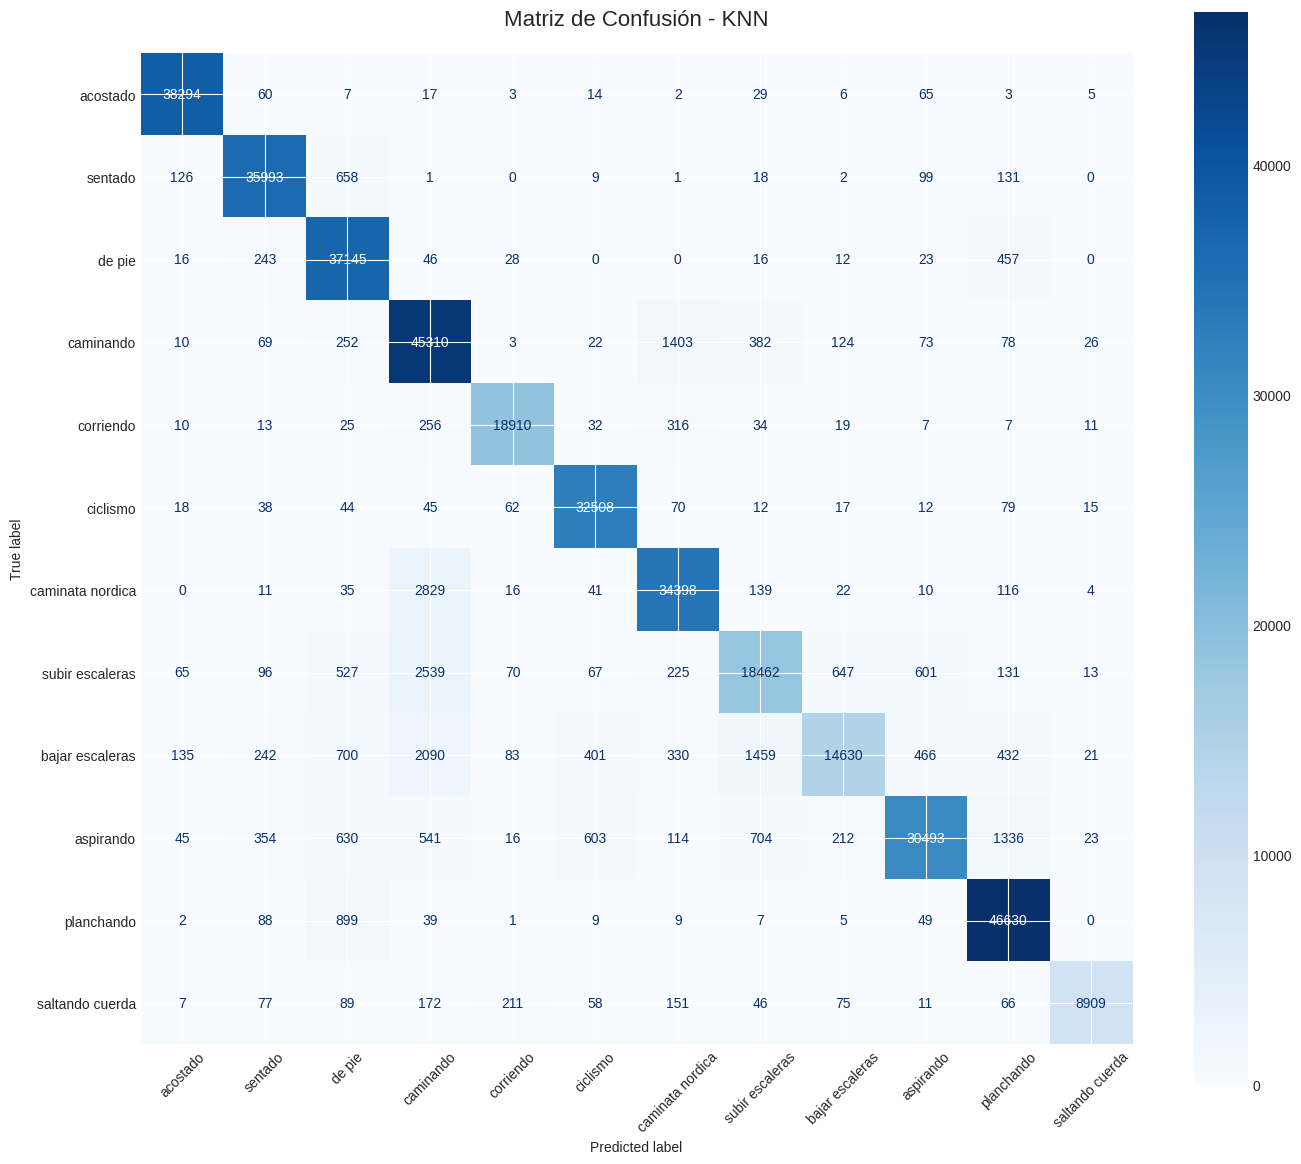


=== Accuracy por Actividad ===
acostado            : 0.9945 (38294/38505)
sentado             : 0.9718 (35993/37038)
de pie              : 0.9779 (37145/37986)
caminando           : 0.9489 (45310/47752)
corriendo           : 0.9628 (18910/19640)
ciclismo            : 0.9875 (32508/32920)
caminata nordica    : 0.9143 (34398/37621)
subir escaleras     : 0.7875 (18462/23443)
bajar escaleras     : 0.6970 (14630/20989)
aspirando           : 0.8695 (30493/35071)
planchando          : 0.9768 (46630/47738)
saltando cuerda     : 0.9025 (8909/9872)


In [52]:
if 'y_test_pred' in locals():
    print("=== Matriz de Confusión - KNN ===")
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Obtener las etiquetas únicas ordenadas
    unique_labels = sorted(y_test.unique())
    label_names = [activity_labels.get(int(x), str(x)) for x in unique_labels]
    
    # Visualizar matriz de confusión
    fig, ax = plt.subplots(figsize=(14, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation=45)
    ax.set_title('Matriz de Confusión - KNN', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Calcular accuracy por clase
    print("\n=== Accuracy por Actividad ===")
    for i, label in enumerate(unique_labels):
        class_correct = cm[i, i]
        class_total = cm[i, :].sum()
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        print(f"{label_names[i]:20s}: {class_accuracy:.4f} ({class_correct}/{class_total})")

### 4.5. Validación Cruzada

=== Validación Cruzada - KNN ===
(Usando 3 folds con subconjunto para mayor velocidad)

Validando con 15000 muestras en 3 folds

Scores por fold:
  Fold 1: 0.8886
  Fold 2: 0.8956
  Fold 3: 0.8914

✓ Accuracy promedio: 0.8919
✓ Desviación estándar: 0.0029
✓ Intervalo de confianza: [0.8861, 0.8976]


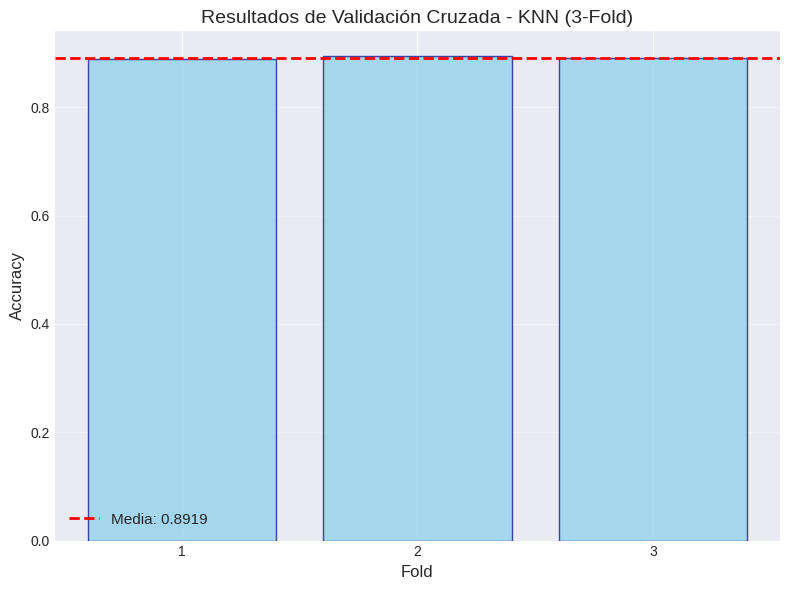


ℹ Nota: Usando OPCIÓN 1 (rápido). Para validación completa, descomentar OPCIÓN 2


In [53]:
if 'knn_final' in locals():
    print("=== Validación Cruzada - KNN ===")
    
    # OPCIÓN 1: RÁPIDO - 3 folds con subconjunto (activo para presentación)
    print("(Usando 3 folds con subconjunto para mayor velocidad)\n")
    cv_subset_size = min(15000, len(X_train_scaled))
    X_cv_subset = X_train_scaled.sample(n=cv_subset_size, random_state=42)
    y_cv_subset = y_train.loc[X_cv_subset.index]
    
    print(f"Validando con {cv_subset_size} muestras en 3 folds")
    
    cv_scores = cross_val_score(
        knn_final, 
        X_cv_subset, 
        y_cv_subset, 
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # OPCIÓN 2: COMPLETO - 5 folds con dataset completo (comentado, descomentar para evaluación final)
    # print("(Validación cruzada completa con 5 folds)\n")
    # print(f"Validando con {len(X_train_scaled)} muestras en 5 folds")
    # cv_scores = cross_val_score(
    #     knn_final, 
    #     X_train_scaled, 
    #     y_train, 
    #     cv=5,
    #     scoring='accuracy',
    #     n_jobs=-1
    # )
    
    print(f"\nScores por fold:")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.4f}")
    
    print(f"\n✓ Accuracy promedio: {cv_scores.mean():.4f}")
    print(f"✓ Desviación estándar: {cv_scores.std():.4f}")
    print(f"✓ Intervalo de confianza: [{cv_scores.mean() - 2*cv_scores.std():.4f}, {cv_scores.mean() + 2*cv_scores.std():.4f}]")
    
    # Visualizar resultados de validación cruzada
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(range(1, len(cv_scores)+1), cv_scores, color='skyblue', edgecolor='navy', alpha=0.7)
    ax.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {cv_scores.mean():.4f}')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'Resultados de Validación Cruzada - KNN ({len(cv_scores)}-Fold)', fontsize=14)
    ax.set_xticks(range(1, len(cv_scores)+1))
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print(f"\nℹ Nota: Usando OPCIÓN 1 (rápido). Para validación completa, descomentar OPCIÓN 2")

### 4.6. Resumen de Resultados - KNN

A continuación se presenta un resumen consolidado del desempeño del algoritmo K-Nearest Neighbors.

In [54]:
if 'y_test_pred' in locals() and 'cv_scores' in locals():
    print("=" * 60)
    print("RESUMEN DE RESULTADOS - K-NEAREST NEIGHBORS (KNN)")
    print("=" * 60)
    
    print("\n📊 CONFIGURACIÓN DEL MODELO:")
    print(f"   • Algoritmo: K-Nearest Neighbors")
    print(f"   • Valor de K: {best_k}")
    print(f"   • Métrica de distancia: Euclidiana")
    print(f"   • Características: {X_train_scaled.shape[1]}")
    
    print("\n📈 MÉTRICAS EN CONJUNTO DE PRUEBA:")
    print(f"   • Accuracy:  {knn_accuracy:.4f}")
    print(f"   • Precision: {knn_precision:.4f}")
    print(f"   • Recall:    {knn_recall:.4f}")
    print(f"   • F1-Score:  {knn_f1:.4f}")
    
    print("\n🔄 VALIDACIÓN CRUZADA (3 o 5 -Fold):")
    print(f"   • Accuracy promedio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"   • Mejor fold: {cv_scores.max():.4f}")
    print(f"   • Peor fold: {cv_scores.min():.4f}")
    
    print("\n✅ ANÁLISIS:")
    if knn_accuracy > 0.90:
        print("   • Excelente rendimiento en la clasificación de actividades")
    elif knn_accuracy > 0.80:
        print("   • Buen rendimiento en la clasificación de actividades")
    elif knn_accuracy > 0.70:
        print("   • Rendimiento aceptable, pero hay margen de mejora")
    else:
        print("   • El modelo requiere ajustes o más características")
    
    print("\n" + "=" * 60)

RESUMEN DE RESULTADOS - K-NEAREST NEIGHBORS (KNN)

📊 CONFIGURACIÓN DEL MODELO:
   • Algoritmo: K-Nearest Neighbors
   • Valor de K: 3
   • Métrica de distancia: Euclidiana
   • Características: 51

📈 MÉTRICAS EN CONJUNTO DE PRUEBA:
   • Accuracy:  0.9308
   • Precision: 0.9322
   • Recall:    0.9308
   • F1-Score:  0.9297

🔄 VALIDACIÓN CRUZADA (3 o 5 -Fold):
   • Accuracy promedio: 0.8919 ± 0.0029
   • Mejor fold: 0.8956
   • Peor fold: 0.8886

✅ ANÁLISIS:
   • Excelente rendimiento en la clasificación de actividades



## 5. Algoritmo 2: Árbol de Decisión (Decision Tree)

### 5.1. Descripción del Algoritmo

Un **Árbol de Decisión** es un modelo de aprendizaje supervisado que divide los datos en subgrupos mediante reglas basadas en características, formando una estructura de árbol. Utiliza criterios como Gini o Entropía para seleccionar la mejor división en cada nodo.

**Ventajas:**
- Fácil de interpretar y visualizar
- No requiere normalización de datos
- Maneja datos categóricos y numéricos
- Poca preparación de datos (robusto a outliers)

**Desventajas:**
- Propenso a sobreajuste (overfitting)
- Inestable ante pequeños cambios en los datos
- Tendencia a crear árboles complejos y sesgados
- Generalización limitada si no se regulariza (poda)

### 5.2. Búsqueda de Hiperparámetros

In [19]:
if 'X_train_scaled' in locals():
    print("=== Búsqueda de Hiperparámetros - Árbol de Decisión ===")
    
    # Subconjunto rápido para la búsqueda
    dt_search_size = min(20000, len(X_train_scaled))
    X_dt_search = X_train_scaled.sample(n=dt_search_size, random_state=42)
    y_dt_search = y_train.loc[X_dt_search.index]
    print(f"Usando {dt_search_size} muestras para GridSearch (3 folds)\n")
    
    dt_param_grid = {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    
    dt_grid = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        dt_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    dt_grid.fit(X_dt_search, y_dt_search)
    
    dt_best_params = dt_grid.best_params_
    dt_best_score = dt_grid.best_score_
    print(f"✓ Mejores hiperparámetros: {dt_best_params}")
    print(f"✓ Accuracy (CV 3 folds, subset): {dt_best_score:.4f}")

=== Búsqueda de Hiperparámetros - Árbol de Decisión ===
Usando 20000 muestras para GridSearch (3 folds)

✓ Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
✓ Accuracy (CV 3 folds, subset): 0.9262


### 5.3. Entrenamiento y Predicción

In [20]:
if 'dt_best_params' in locals():
    print("=== Entrenamiento del Árbol de Decisión Final ===")
    
    # OPCIÓN 1: RÁPIDO - entrenar con subconjunto
    dt_train_size = min(50000, len(X_train_scaled))
    X_dt_train = X_train_scaled.sample(n=dt_train_size, random_state=42)
    y_dt_train = y_train.loc[X_dt_train.index]
    print(f"Entrenando con {dt_train_size} muestras (de {len(X_train_scaled)})\n")
    
    dt_final = DecisionTreeClassifier(**dt_best_params, random_state=42)
    dt_final.fit(X_dt_train, y_dt_train)
    
    # OPCIÓN 2: COMPLETO - descomentar para usar todo el dataset
    # dt_final = DecisionTreeClassifier(**dt_best_params, random_state=42)
    # dt_final.fit(X_train_scaled, y_train)
    
    print("✓ Árbol entrenado")
    dt_y_pred = dt_final.predict(X_test_scaled)
    print("✓ Predicciones en conjunto de prueba listas")

=== Entrenamiento del Árbol de Decisión Final ===
Entrenando con 50000 muestras (de 1554297)

✓ Árbol entrenado
✓ Predicciones en conjunto de prueba listas


### 5.4. Evaluación del Árbol de Decisión

=== Métricas de Evaluación - Árbol de Decisión ===

Accuracy:  0.9687
Precision: 0.9687
Recall:    0.9687
F1-Score:  0.9687



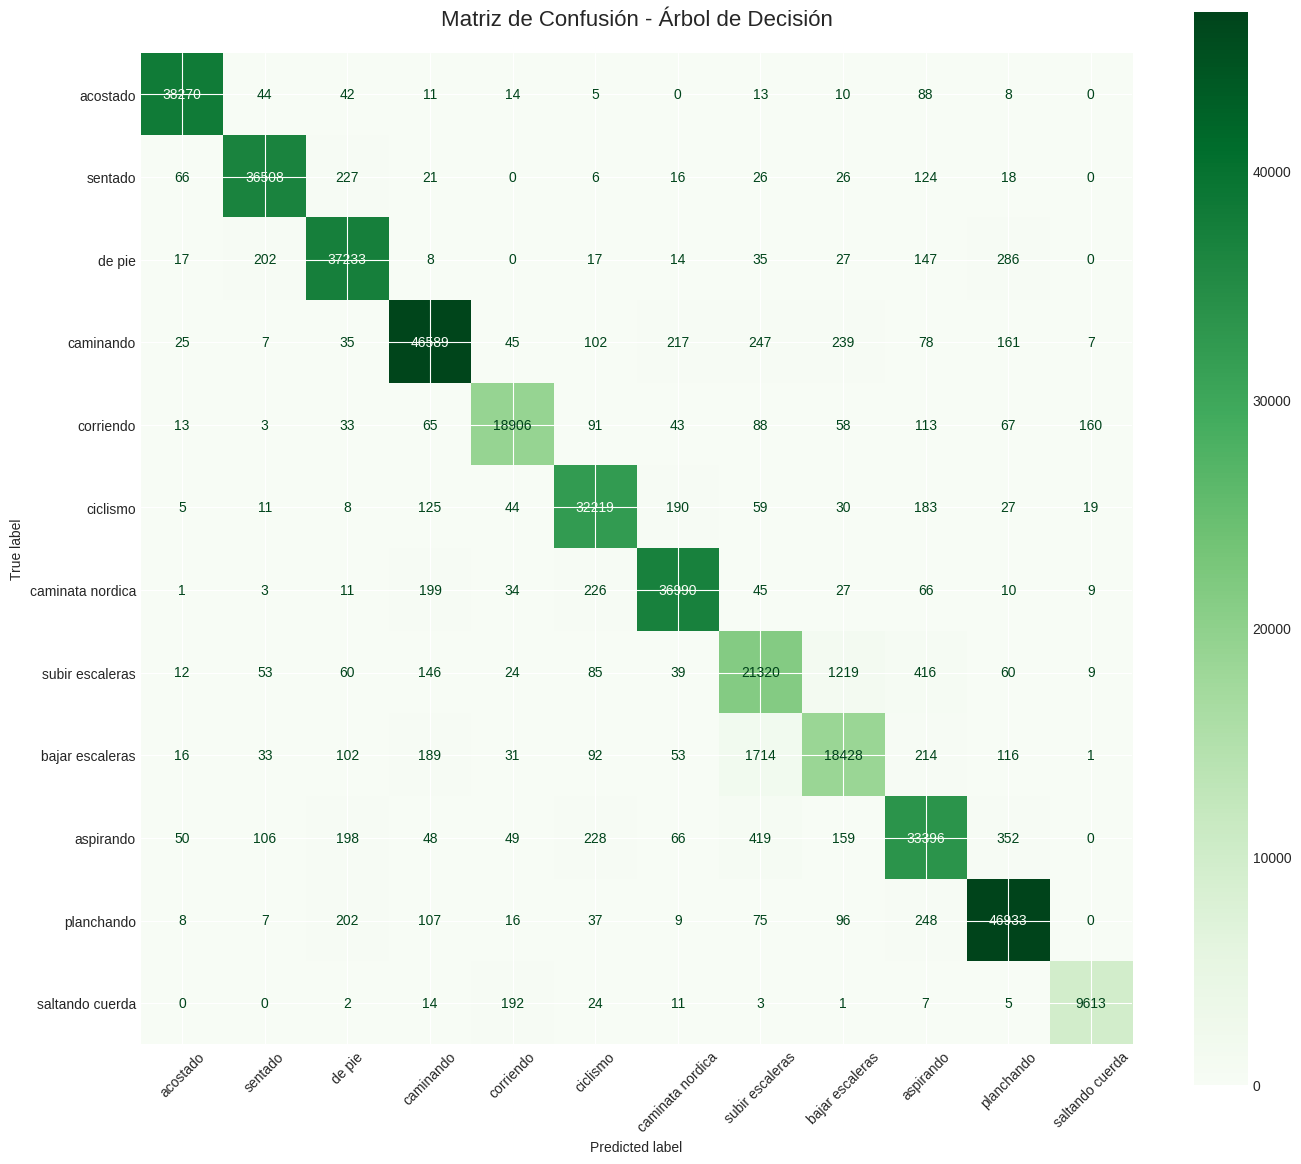

=== Accuracy por Actividad ===
acostado            : 0.9939 (38270/38505)
sentado             : 0.9857 (36508/37038)
de pie              : 0.9802 (37233/37986)
caminando           : 0.9756 (46589/47752)
corriendo           : 0.9626 (18906/19640)
ciclismo            : 0.9787 (32219/32920)
caminata nordica    : 0.9832 (36990/37621)
subir escaleras     : 0.9094 (21320/23443)
bajar escaleras     : 0.8780 (18428/20989)
aspirando           : 0.9522 (33396/35071)
planchando          : 0.9831 (46933/47738)
saltando cuerda     : 0.9738 (9613/9872)


In [21]:
if 'dt_y_pred' in locals():
    print("=== Métricas de Evaluación - Árbol de Decisión ===\n")
    dt_accuracy = accuracy_score(y_test, dt_y_pred)
    dt_precision = precision_score(y_test, dt_y_pred, average='weighted', zero_division=0)
    dt_recall = recall_score(y_test, dt_y_pred, average='weighted', zero_division=0)
    dt_f1 = f1_score(y_test, dt_y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {dt_accuracy:.4f}")
    print(f"Precision: {dt_precision:.4f}")
    print(f"Recall:    {dt_recall:.4f}")
    print(f"F1-Score:  {dt_f1:.4f}\n")
    
    # Matriz de confusión y accuracy por clase
    dt_cm = confusion_matrix(y_test, dt_y_pred)
    dt_labels = sorted(y_test.unique())
    dt_names = [activity_labels.get(int(x), str(x)) for x in dt_labels]
    
    fig, ax = plt.subplots(figsize=(14, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=dt_names)
    disp.plot(ax=ax, cmap='Greens', values_format='d', xticks_rotation=45)
    ax.set_title('Matriz de Confusión - Árbol de Decisión', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    print("=== Accuracy por Actividad ===")
    for i, label in enumerate(dt_labels):
        cls_correct = dt_cm[i, i]
        cls_total = dt_cm[i, :].sum()
        cls_acc = cls_correct / cls_total if cls_total > 0 else 0
        print(f"{dt_names[i]:20s}: {cls_acc:.4f} ({cls_correct}/{cls_total})")

### 5.5. Visualización del Árbol de Decisión

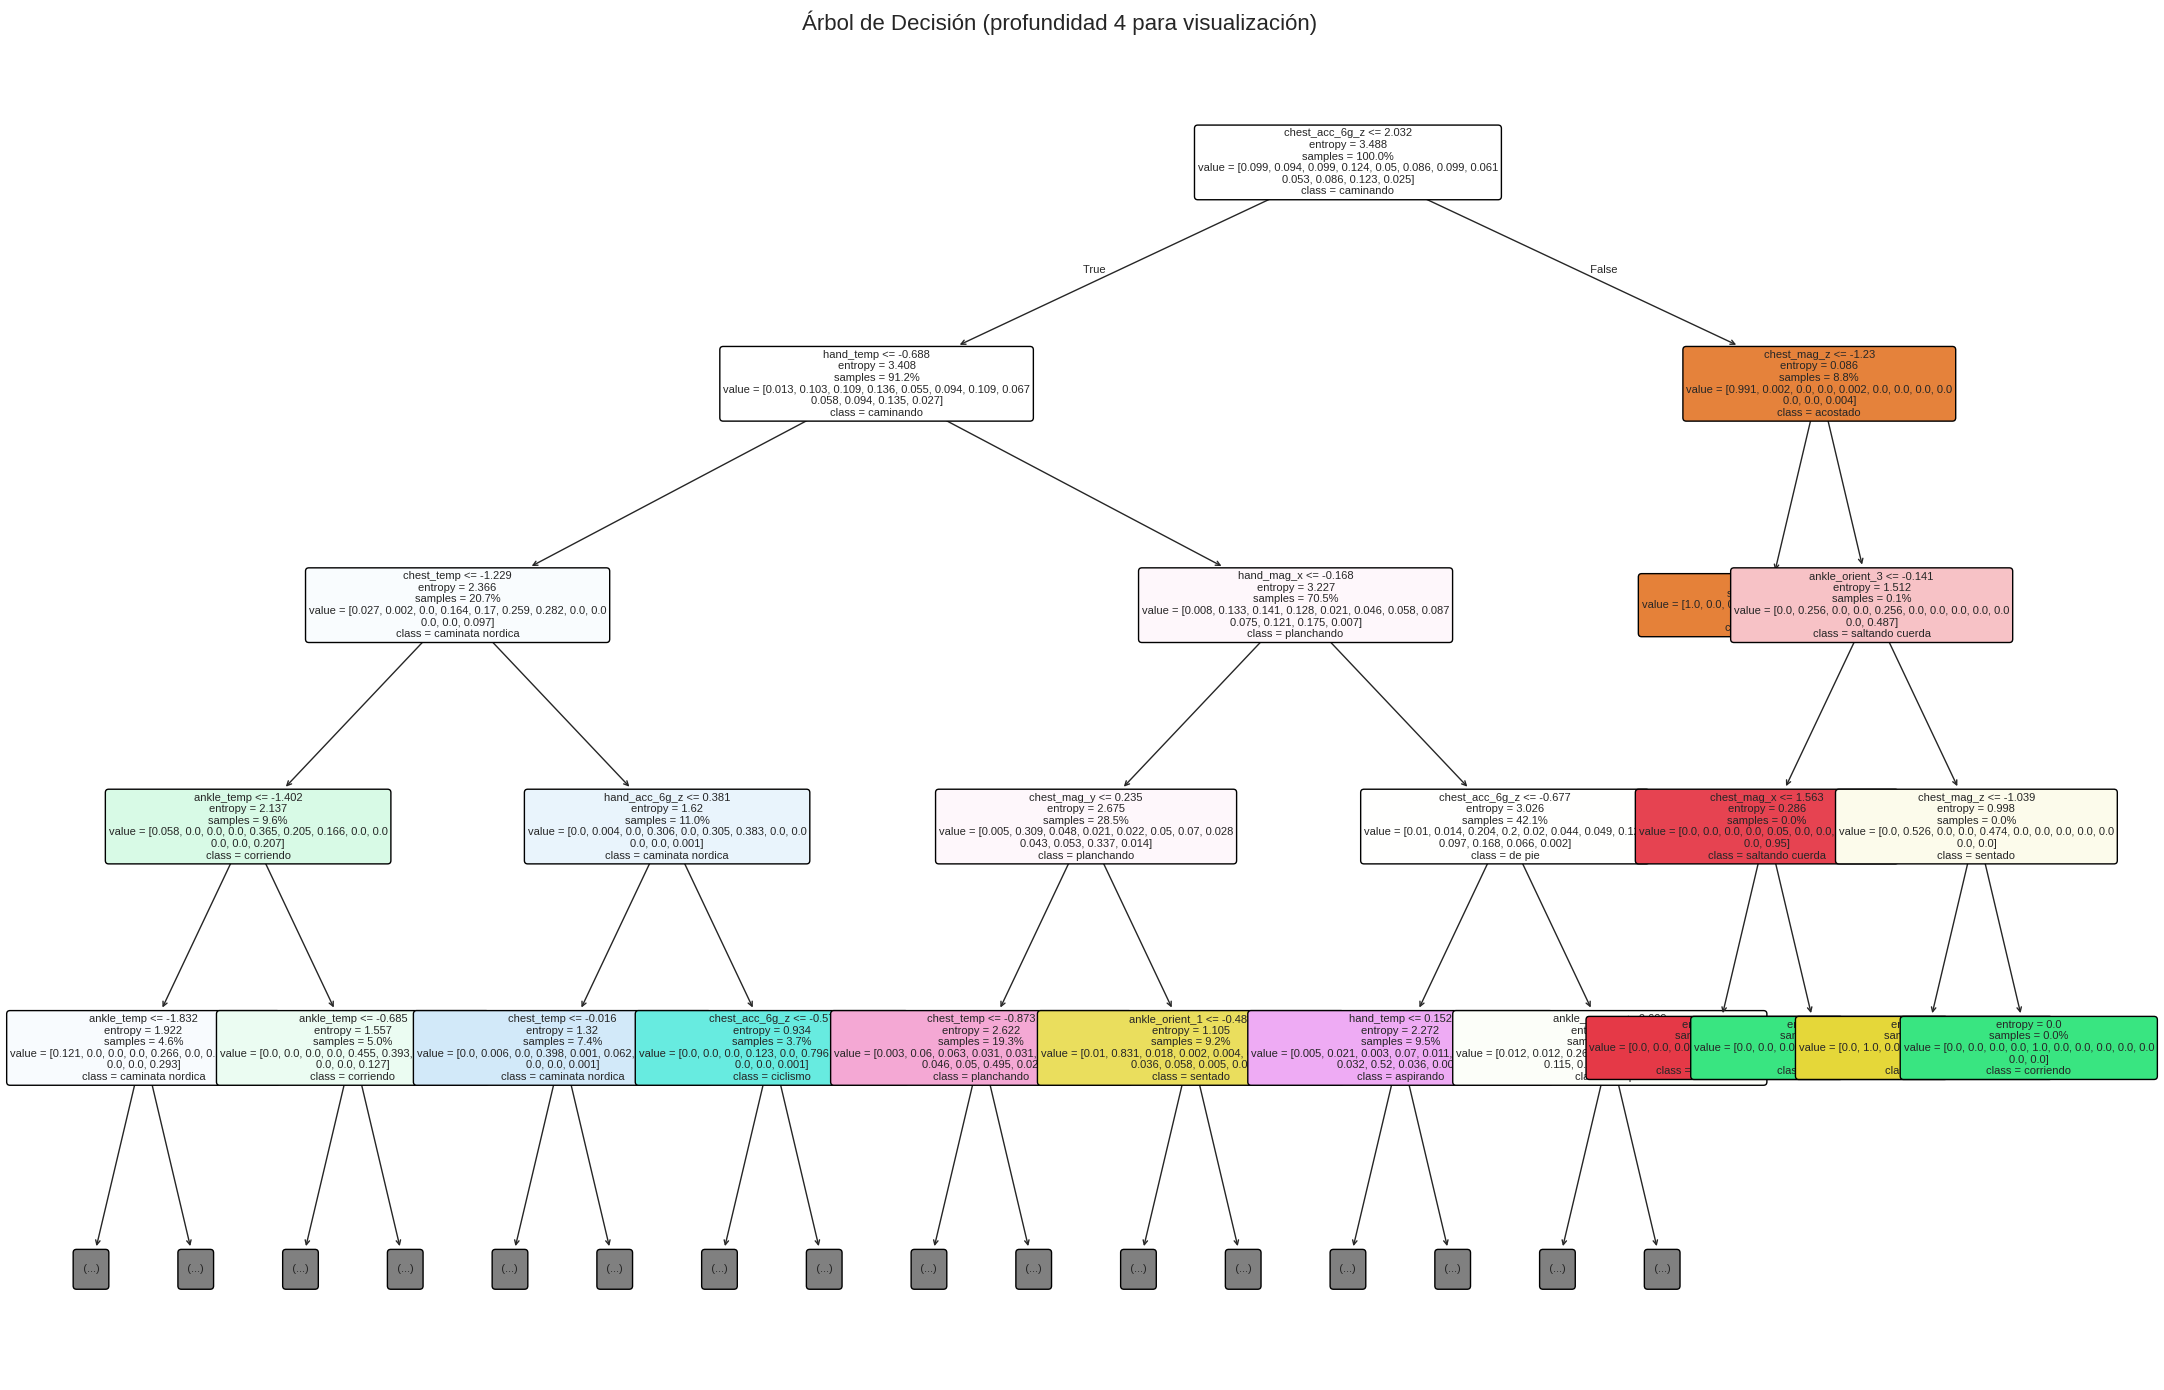

In [22]:
# Visualización del árbol (profundidad limitada para legibilidad)
if 'dt_final' in locals():
    from sklearn.tree import plot_tree

    feature_names = X_train.columns.tolist() if 'X_train' in locals() else None
    class_names = [activity_labels.get(int(c), str(c)) for c in dt_final.classes_] if 'activity_labels' in locals() else [str(c) for c in dt_final.classes_]

    plt.figure(figsize=(22, 14))
    plot_tree(
        dt_final,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        max_depth=4,
        fontsize=8,
        proportion=True,
        rounded=True,
    )
    plt.title('Árbol de Decisión (profundidad 4 para visualización)', fontsize=16, pad=16)
    plt.tight_layout()
    plt.show()

### 5.6. Validación Cruzada

=== Validación Cruzada - Árbol de Decisión ===
Validando con 15000 muestras en 3 folds

Scores por fold:
  Fold 1: 0.8908
  Fold 2: 0.9224
  Fold 3: 0.9152

✓ Accuracy promedio: 0.9095
✓ Desviación estándar: 0.0135
✓ Intervalo de confianza: [0.8824, 0.9365]


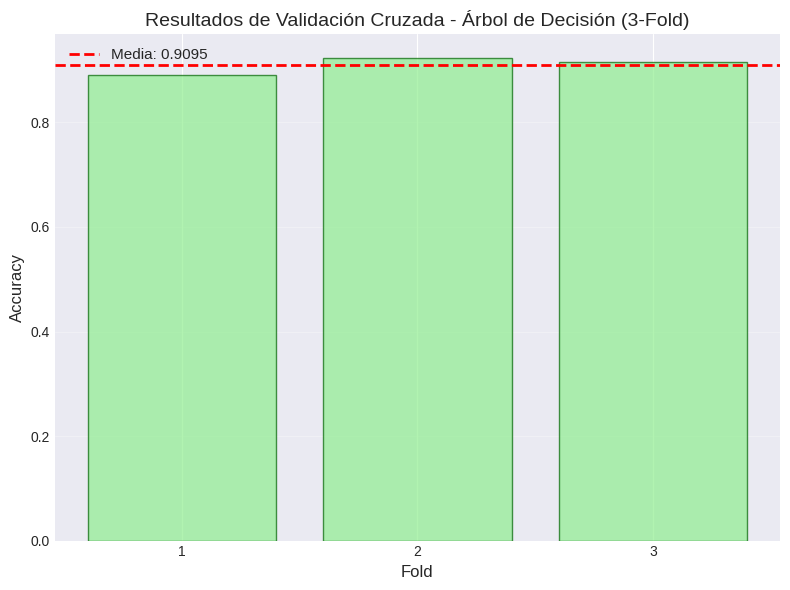


ℹ Nota: Usando OPCIÓN 1 (rápido). Para validación completa, ajustar a 5 folds con todo el dataset si el tiempo lo permite


In [27]:
if 'dt_final' in locals():
    print("=== Validación Cruzada - Árbol de Decisión ===")
    
    # OPCIÓN 1: RÁPIDO - 3 folds con subconjunto
    dt_cv_size = min(15000, len(X_train_scaled))
    X_dt_cv = X_train_scaled.sample(n=dt_cv_size, random_state=42)
    y_dt_cv = y_train.loc[X_dt_cv.index]
    print(f"Validando con {dt_cv_size} muestras en 3 folds\n")
    
    dt_cv_model = DecisionTreeClassifier(**dt_best_params, random_state=42)
    dt_cv_scores = cross_val_score(
        dt_cv_model,
        X_dt_cv,
        y_dt_cv,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    
    print("Scores por fold:")
    for i, score in enumerate(dt_cv_scores, 1):
        print(f"  Fold {i}: {score:.4f}")
    
    print(f"\n✓ Accuracy promedio: {dt_cv_scores.mean():.4f}")
    print(f"✓ Desviación estándar: {dt_cv_scores.std():.4f}")
    print(f"✓ Intervalo de confianza: [{dt_cv_scores.mean() - 2*dt_cv_scores.std():.4f}, {dt_cv_scores.mean() + 2*dt_cv_scores.std():.4f}]")
    
    # Visualizar resultados de validación cruzada
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(range(1, len(dt_cv_scores)+1), dt_cv_scores, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
    ax.axhline(y=dt_cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {dt_cv_scores.mean():.4f}')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'Resultados de Validación Cruzada - Árbol de Decisión ({len(dt_cv_scores)}-Fold)', fontsize=14)
    ax.set_xticks(range(1, len(dt_cv_scores)+1))
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Nota para opción completa
    print("\nℹ Nota: Usando OPCIÓN 1 (rápido). Para validación completa, ajustar a 5 folds con todo el dataset si el tiempo lo permite")

### 5.7. Resumen de Resultados - Árbol de Decisión

In [28]:
if 'dt_y_pred' in locals():
    print("=" * 60)
    print("RESUMEN DE RESULTADOS - ÁRBOL DE DECISIÓN")
    print("=" * 60)
    
    print("\n📊 CONFIGURACIÓN DEL MODELO:")
    print(f"   • Algoritmo: Decision Tree")
    print(f"   • Hiperparámetros: {dt_best_params}")
    print(f"   • Características: {X_train_scaled.shape[1]}")
    
    print("\n📈 MÉTRICAS EN CONJUNTO DE PRUEBA:")
    print(f"   • Accuracy:  {dt_accuracy:.4f}")
    print(f"   • Precision: {dt_precision:.4f}")
    print(f"   • Recall:    {dt_recall:.4f}")
    print(f"   • F1-Score:  {dt_f1:.4f}")
    
    if 'dt_cv_scores' in locals():
        print("\n🔄 VALIDACIÓN CRUZADA (3 folds, subset):")
        print(f"   • Accuracy promedio: {dt_cv_scores.mean():.4f} ± {dt_cv_scores.std():.4f}")
        print(f"   • Mejor fold: {dt_cv_scores.max():.4f}")
        print(f"   • Peor fold: {dt_cv_scores.min():.4f}")
    
    print("\n✅ ANÁLISIS:")
    if dt_accuracy > 0.90:
        print("   • Excelente rendimiento en la clasificación de actividades")
    elif dt_accuracy > 0.80:
        print("   • Buen rendimiento en la clasificación de actividades")
    elif dt_accuracy > 0.70:
        print("   • Rendimiento aceptable, hay margen de mejora")
    else:
        print("   • El modelo requiere ajustes o más características")
    
    print("\n" + "=" * 60)

RESUMEN DE RESULTADOS - ÁRBOL DE DECISIÓN

📊 CONFIGURACIÓN DEL MODELO:
   • Algoritmo: Decision Tree
   • Hiperparámetros: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
   • Características: 51

📈 MÉTRICAS EN CONJUNTO DE PRUEBA:
   • Accuracy:  0.9687
   • Precision: 0.9687
   • Recall:    0.9687
   • F1-Score:  0.9687

🔄 VALIDACIÓN CRUZADA (3 folds, subset):
   • Accuracy promedio: 0.9095 ± 0.0135
   • Mejor fold: 0.9224
   • Peor fold: 0.8908

✅ ANÁLISIS:
   • Excelente rendimiento en la clasificación de actividades



## 6. Algoritmo 3: Red Neuronal Artificial (MLP)

### 6.1. Descripción del Algoritmo

El **Perceptrón Multicapa (MLP)** es una red neuronal artificial feedforward compuesta por múltiples capas de neuronas. Aprende representaciones no lineales mediante funciones de activación y propagación hacia atrás (backpropagation).

**Ventajas:**
- Capaz de aprender patrones complejos y no lineales
- Excelente para datos multivariados como señales sensoriales
- Puede capturar interacciones entre características
- Escalable a grandes volúmenes de datos

**Desventajas:**
- Requiere más tiempo de entrenamiento
- Sensible a la escala de las características (requiere normalización)
- Puede sobreajustar sin regularización adecuada
- Más difícil de interpretar que otros modelos

### 6.2. Optimización de Hiperparámetros

In [29]:
print("=" * 70)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - RED NEURONAL MLP")
print("=" * 70)

# Definir el espacio de búsqueda para MLP
mlp_param_grid = {
    'hidden_layer_sizes': [
        (100,),           # 1 capa oculta con 100 neuronas
        (100, 50),        # 2 capas: 100 y 50 neuronas
        (128, 64, 32),    # 3 capas: 128, 64 y 32 neuronas
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # Regularización L2
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [500]  # Iteraciones máximas
}

print("\n📋 Configuración de búsqueda:")
print(f"   • Arquitecturas a probar: {len(mlp_param_grid['hidden_layer_sizes'])}")
print(f"   • Funciones de activación: {mlp_param_grid['activation']}")
print(f"   • Valores de regularización (alpha): {mlp_param_grid['alpha']}")
print(f"   • Learning rates: {mlp_param_grid['learning_rate_init']}")
print(f"   • Máximo de iteraciones: {mlp_param_grid['max_iter'][0]}")

# Calcular combinaciones totales
total_combinations = 1
for values in mlp_param_grid.values():
    total_combinations *= len(values)
print(f"\n⚙️  Total de combinaciones: {total_combinations}")

# Usar subconjunto para acelerar la búsqueda (ajustable según recursos)
mlp_grid_size = min(10000, len(X_train_scaled))
X_mlp_grid = X_train_scaled.sample(n=mlp_grid_size, random_state=42)
y_mlp_grid = y_train.loc[X_mlp_grid.index]
print(f"📊 Usando {mlp_grid_size:,} muestras para GridSearch con 3-fold CV")

print("\n🔄 Iniciando búsqueda de hiperparámetros...")
print("⏱️  Esto puede tomar varios minutos...\n")

# GridSearch con validación cruzada
mlp_grid_search = GridSearchCV(
    MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1),
    mlp_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

mlp_grid_search.fit(X_mlp_grid, y_mlp_grid)

# Resultados
print("\n✅ Búsqueda completada!")
print(f"\n🏆 Mejores hiperparámetros encontrados:")
mlp_best_params = mlp_grid_search.best_params_
for param, value in mlp_best_params.items():
    print(f"   • {param}: {value}")

print(f"\n📊 Mejor score en validación cruzada: {mlp_grid_search.best_score_:.4f}")
print(f"📉 Mejora respecto al peor modelo: {mlp_grid_search.best_score_ - min(mlp_grid_search.cv_results_['mean_test_score']):.4f}")

print("\n" + "=" * 70)

OPTIMIZACIÓN DE HIPERPARÁMETROS - RED NEURONAL MLP

📋 Configuración de búsqueda:
   • Arquitecturas a probar: 3
   • Funciones de activación: ['relu', 'tanh']
   • Valores de regularización (alpha): [0.0001, 0.001, 0.01]
   • Learning rates: [0.001, 0.01]
   • Máximo de iteraciones: 500

⚙️  Total de combinaciones: 36
📊 Usando 10,000 muestras para GridSearch con 3-fold CV

🔄 Iniciando búsqueda de hiperparámetros...
⏱️  Esto puede tomar varios minutos...

Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ Búsqueda completada!

🏆 Mejores hiperparámetros encontrados:
   • activation: relu
   • alpha: 0.01
   • hidden_layer_sizes: (100,)
   • learning_rate_init: 0.01
   • max_iter: 500

📊 Mejor score en validación cruzada: 0.9164
📉 Mejora respecto al peor modelo: 0.0340



### 6.3. Entrenamiento del Modelo Final

In [36]:
print("=" * 70)
print("ENTRENAMIENTO DEL MODELO FINAL - RED NEURONAL MLP")
print("=" * 70)

# Crear el modelo con los mejores parámetros
mlp_final = MLPClassifier(
    **mlp_best_params,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True
)

print("\n🏗️  Arquitectura del modelo:")
print(f"   • Capas ocultas: {mlp_best_params['hidden_layer_sizes']}")
print(f"   • Función de activación: {mlp_best_params['activation']}")
print(f"   • Alpha (regularización L2): {mlp_best_params['alpha']}")
print(f"   • Learning rate inicial: {mlp_best_params['learning_rate_init']}")
print(f"   • Early stopping: Activado")

# ========================================================================
# OPCIÓN 1: RÁPIDO - Subconjunto de 50k para entrenar más rápido
# ========================================================================
mlp_train_size = min(50000, len(X_train_scaled))
X_mlp_train = X_train_scaled.sample(n=mlp_train_size, random_state=42)
y_mlp_train = y_train.loc[X_mlp_train.index]

print("\n📊 Datos de entrenamiento:")
print(f"   • Muestras de entrenamiento: {mlp_train_size:,} (de {len(X_train_scaled):,} disponibles)")
print(f"   • Características: {X_train_scaled.shape[1]}")
print(f"   • Clases: {len(np.unique(y_train))}")

print("\n⏱️  Entrenando red neuronal (subconjunto 50k)...")
print("="*70)

import time
mlp_start_time = time.time()

# Entrenar el modelo con el subconjunto
mlp_final.fit(X_mlp_train, y_mlp_train)

mlp_training_time = time.time() - mlp_start_time

print("\n" + "="*70)
print("✅ Entrenamiento completado!")
print(f"⏱️  Tiempo de entrenamiento: {mlp_training_time:.2f} segundos")
print(f"🔄 Iteraciones realizadas: {mlp_final.n_iter_}")
print(f"📉 Loss final: {mlp_final.loss_:.6f}")

if hasattr(mlp_final, 'best_loss_') and mlp_final.best_loss_ is not None:
    print(f"🎯 Mejor loss (validación): {mlp_final.best_loss_:.6f}")

print("\n📐 Estructura de la red entrenada:")
print(f"   • Número de capas: {mlp_final.n_layers_}")
print(f"   • Neuronas por capa de salida: {mlp_final.n_outputs_}")

# ========================================================================
# OPCIÓN 2: COMPLETO - Dataset completo para resultados finales (comentada)
# ========================================================================
# print("\n📊 Datos de entrenamiento (completo):")
# print(f"   • Muestras de entrenamiento: {len(X_train_scaled):,}")
# print(f"   • Características: {X_train_scaled.shape[1]}")
# print(f"   • Clases: {len(np.unique(y_train))}")
# 
# print("\n⏱️  Entrenando red neuronal en el dataset completo...")
# print("="*70)
# mlp_start_time = time.time()
# mlp_final.fit(X_train_scaled, y_train)
# mlp_training_time = time.time() - mlp_start_time
# print("\n" + "="*70)
# print("✅ Entrenamiento completado (dataset completo)!")
# print(f"⏱️  Tiempo de entrenamiento: {mlp_training_time:.2f} segundos")
# print(f"🔄 Iteraciones realizadas: {mlp_final.n_iter_}")
# print(f"📉 Loss final: {mlp_final.loss_:.6f}")
# if hasattr(mlp_final, 'best_loss_') and mlp_final.best_loss_ is not None:
#     print(f"🎯 Mejor loss (validación): {mlp_final.best_loss_:.6f}")
# print("\n📐 Estructura de la red entrenada:")
# print(f"   • Número de capas: {mlp_final.n_layers_}")
# print(f"   • Neuronas por capa de salida: {mlp_final.n_outputs_}")

print("\n" + "=" * 70)

ENTRENAMIENTO DEL MODELO FINAL - RED NEURONAL MLP

🏗️  Arquitectura del modelo:
   • Capas ocultas: (100,)
   • Función de activación: relu
   • Alpha (regularización L2): 0.01
   • Learning rate inicial: 0.01
   • Early stopping: Activado

📊 Datos de entrenamiento:
   • Muestras de entrenamiento: 50,000 (de 1,554,297 disponibles)
   • Características: 51
   • Clases: 12

⏱️  Entrenando red neuronal (subconjunto 50k)...
Iteration 1, loss = 0.49223426
Validation score: 0.914200
Iteration 2, loss = 0.22603649
Validation score: 0.938800
Iteration 3, loss = 0.17948105
Validation score: 0.943800
Iteration 4, loss = 0.15965972
Validation score: 0.943200
Iteration 5, loss = 0.14551512
Validation score: 0.948000
Iteration 6, loss = 0.13497118
Validation score: 0.948800
Iteration 7, loss = 0.12861732
Validation score: 0.955200
Iteration 8, loss = 0.12226979
Validation score: 0.956000
Iteration 9, loss = 0.12507346
Validation score: 0.955000
Iteration 10, loss = 0.11682893
Validation score: 0.95

### 6.4. Evaluación en Conjunto de Prueba

In [37]:
print("=" * 70)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA - RED NEURONAL MLP")
print("=" * 70)

# Realizar predicciones
print("\n🔮 Realizando predicciones en el conjunto de prueba...")
mlp_y_pred = mlp_final.predict(X_test_scaled)

# Calcular métricas
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)
mlp_precision = precision_score(y_test, mlp_y_pred, average='weighted', zero_division=0)
mlp_recall = recall_score(y_test, mlp_y_pred, average='weighted', zero_division=0)
mlp_f1 = f1_score(y_test, mlp_y_pred, average='weighted', zero_division=0)

print("\n📊 MÉTRICAS DE RENDIMIENTO:")
print(f"   • Accuracy:  {mlp_accuracy:.4f} ({mlp_accuracy*100:.2f}%)")
print(f"   • Precision: {mlp_precision:.4f} ({mlp_precision*100:.2f}%)")
print(f"   • Recall:    {mlp_recall:.4f} ({mlp_recall*100:.2f}%)")
print(f"   • F1-Score:  {mlp_f1:.4f} ({mlp_f1*100:.2f}%)")

# Reporte de clasificación detallado
print("\n📋 REPORTE DE CLASIFICACIÓN POR CLASE:")
print("-" * 70)
mlp_report = classification_report(y_test, mlp_y_pred, target_names=[str(i) for i in sorted(y_test.unique())])
print(mlp_report)

print("=" * 70)

EVALUACIÓN EN CONJUNTO DE PRUEBA - RED NEURONAL MLP

🔮 Realizando predicciones en el conjunto de prueba...



📊 MÉTRICAS DE RENDIMIENTO:
   • Accuracy:  0.9666 (96.66%)
   • Precision: 0.9668 (96.68%)
   • Recall:    0.9666 (96.66%)
   • F1-Score:  0.9664 (96.64%)

📋 REPORTE DE CLASIFICACIÓN POR CLASE:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.99      1.00      0.99     38505
           2       0.99      0.98      0.99     37038
           3       0.97      0.97      0.97     37986
           4       0.95      0.98      0.97     47752
           5       0.97      0.98      0.97     19640
           6       0.99      0.99      0.99     32920
           7       0.98      0.98      0.98     37621
          12       0.88      0.92      0.90     23443
          13       0.95      0.83      0.89     20989
          16       0.96      0.96      0.96     35071
          17       0.96      0.98      0.97     47738
          24       0.97      0.96      0.97      9872

    accuracy                  

### 6.5. Matriz de Confusión

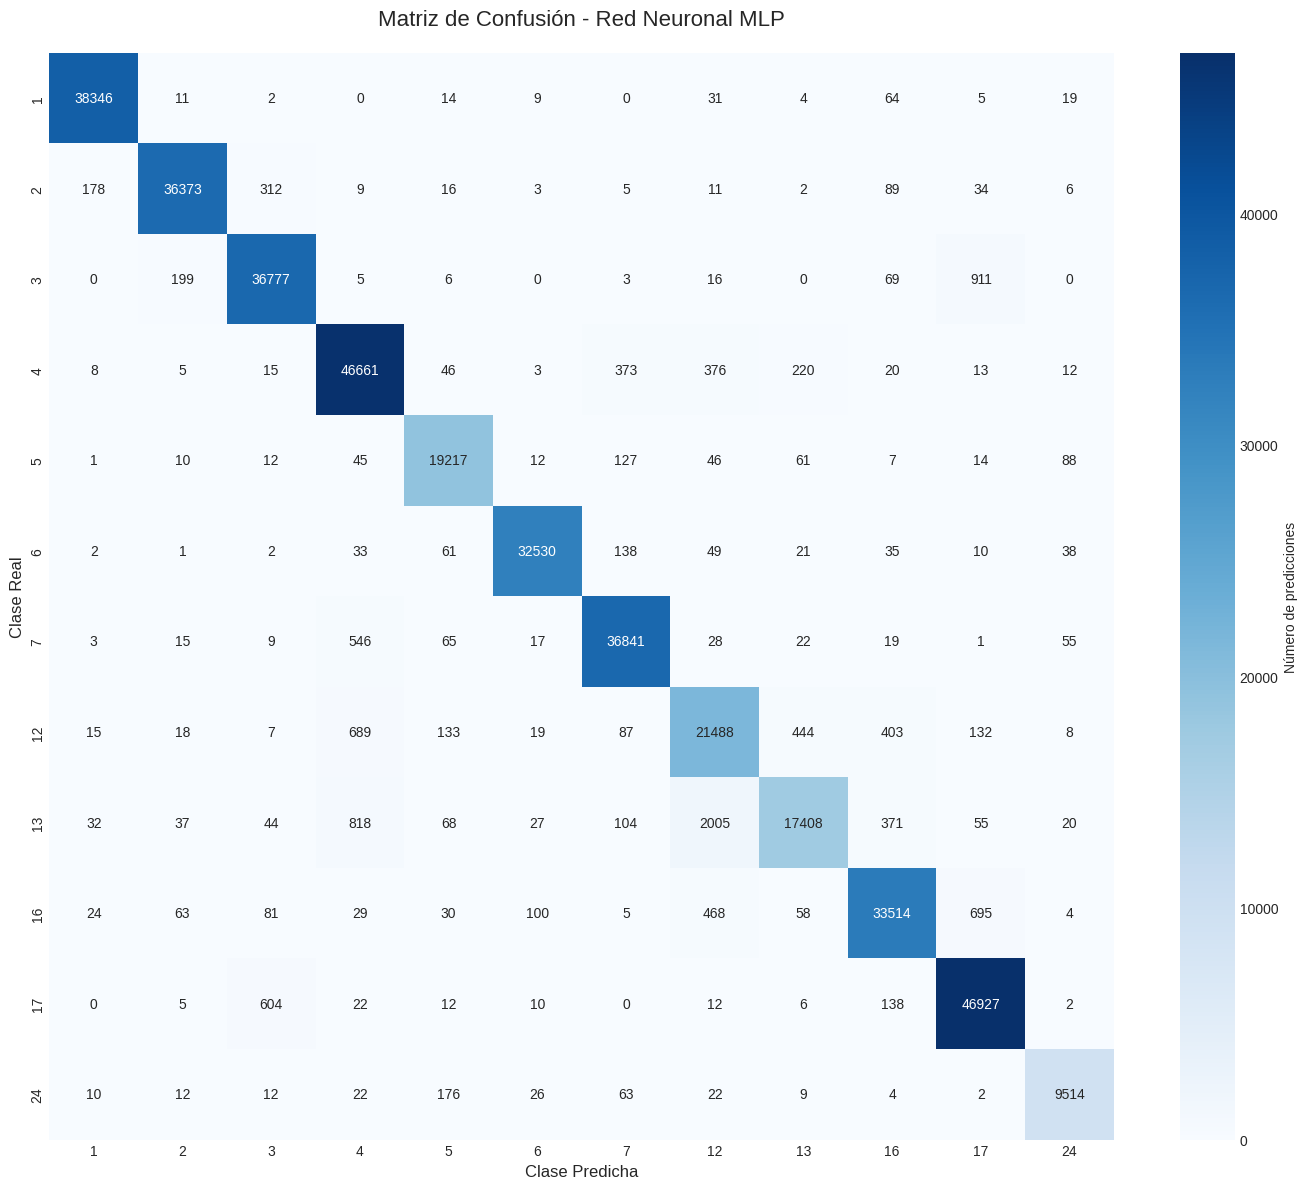


🔍 Análisis de confusiones más comunes:
----------------------------------------------------------------------
Top 5 confusiones (clase real → clase predicha):
   • Clase 8 → Clase 7: 2005 errores
   • Clase 2 → Clase 10: 911 errores
   • Clase 8 → Clase 3: 818 errores
   • Clase 9 → Clase 10: 695 errores
   • Clase 7 → Clase 3: 689 errores



In [38]:
# Calcular matriz de confusión
mlp_cm = confusion_matrix(y_test, mlp_y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(14, 12))
sns.heatmap(
    mlp_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sorted(y_test.unique()),
    yticklabels=sorted(y_test.unique()),
    cbar_kws={'label': 'Número de predicciones'}
)
plt.xlabel('Clase Predicha', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.title('Matriz de Confusión - Red Neuronal MLP', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Análisis de errores más comunes
print("\n🔍 Análisis de confusiones más comunes:")
print("-" * 70)

# Encontrar las 5 confusiones más frecuentes (excluyendo la diagonal)
mlp_errors = []
for i in range(len(mlp_cm)):
    for j in range(len(mlp_cm)):
        if i != j and mlp_cm[i, j] > 0:
            mlp_errors.append((mlp_cm[i, j], i, j))

mlp_errors.sort(reverse=True)
print("Top 5 confusiones (clase real → clase predicha):")
for count, true_class, pred_class in mlp_errors[:5]:
    print(f"   • Clase {true_class} → Clase {pred_class}: {count} errores")

print("\n" + "=" * 70)

### 6.6. Curva de Aprendizaje

📈 Visualizando curva de aprendizaje (pérdida durante entrenamiento)...



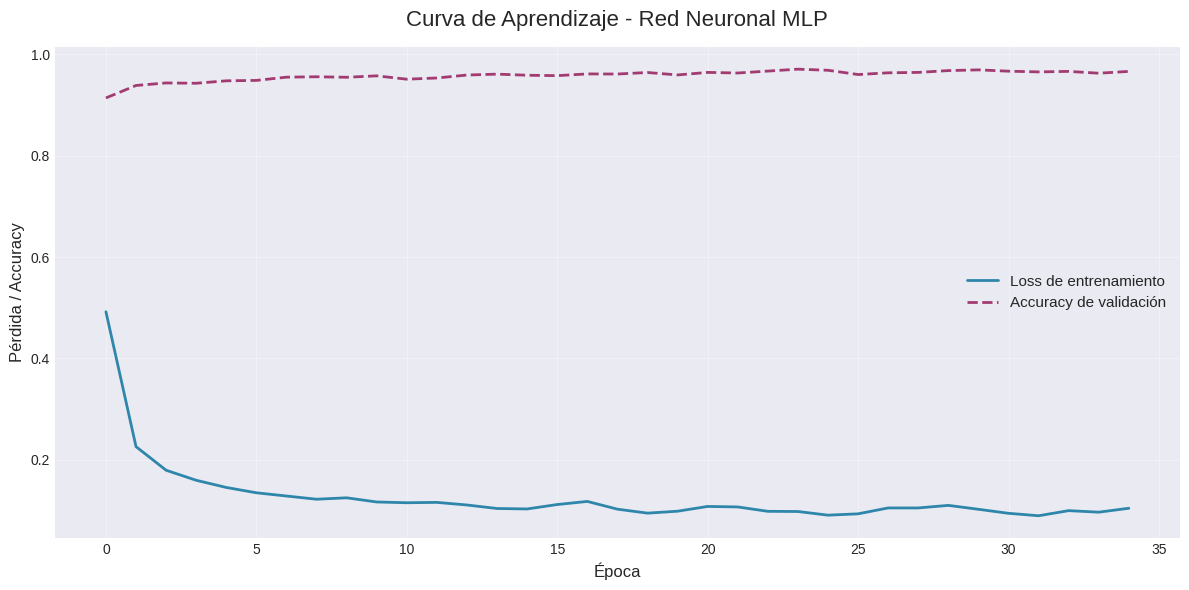

📊 Análisis de convergencia:
   • Pérdida inicial: 0.492234
   • Pérdida final: 0.104465
   • Reducción de pérdida: 0.387770
   • Épocas de entrenamiento: 35
   ✅ Convergencia temprana activada - detuvo en época 35



In [39]:
if hasattr(mlp_final, 'loss_curve_'):
    print("📈 Visualizando curva de aprendizaje (pérdida durante entrenamiento)...\n")
    
    plt.figure(figsize=(12, 6))
    
    # Gráfico de la curva de pérdida
    plt.plot(mlp_final.loss_curve_, linewidth=2, color='#2E86AB', label='Loss de entrenamiento')
    
    if hasattr(mlp_final, 'validation_scores_'):
        # Si hay validación, mostrar también el score de validación
        plt.plot(mlp_final.validation_scores_, linewidth=2, color='#A23B72', 
                label='Accuracy de validación', linestyle='--')
    
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Pérdida / Accuracy', fontsize=12)
    plt.title('Curva de Aprendizaje - Red Neuronal MLP', fontsize=16, pad=15)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Análisis de convergencia
    print("📊 Análisis de convergencia:")
    print(f"   • Pérdida inicial: {mlp_final.loss_curve_[0]:.6f}")
    print(f"   • Pérdida final: {mlp_final.loss_curve_[-1]:.6f}")
    print(f"   • Reducción de pérdida: {mlp_final.loss_curve_[0] - mlp_final.loss_curve_[-1]:.6f}")
    print(f"   • Épocas de entrenamiento: {len(mlp_final.loss_curve_)}")
    
    if len(mlp_final.loss_curve_) < mlp_best_params['max_iter']:
        print(f"   ✅ Convergencia temprana activada - detuvo en época {len(mlp_final.loss_curve_)}")
    else:
        print(f"   ⚠️ Alcanzó el máximo de iteraciones ({mlp_best_params['max_iter']})")
else:
    print("⚠️ No hay información de la curva de aprendizaje disponible")

print("\n" + "=" * 70)

### 6.7. Validación Cruzada

VALIDACIÓN CRUZADA - RED NEURONAL MLP

📊 Validando con 15,000 muestras en 3 folds
⏱️  Esto puede tomar varios minutos...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished



✅ Validación cruzada completada!

📊 Resultados por fold:
   Fold 1: 0.9240 (92.40%)
   Fold 2: 0.9306 (93.06%)
   Fold 3: 0.9280 (92.80%)

📈 ESTADÍSTICAS DE VALIDACIÓN CRUZADA:
   • Accuracy promedio: 0.9275 (92.75%)
   • Desviación estándar: 0.0027
   • Mejor fold: 0.9306
   • Peor fold: 0.9240
   • Rango: 0.0066
   • Intervalo de confianza (95%): [0.9221, 0.9330]


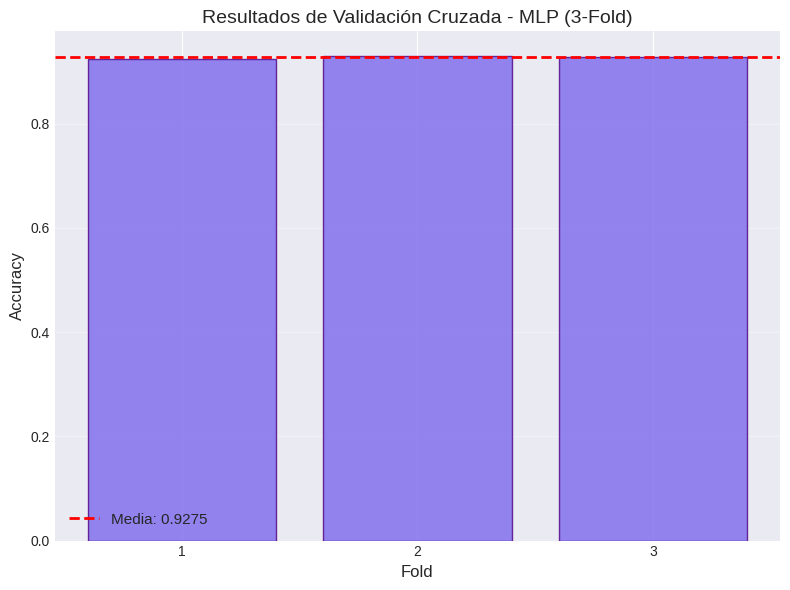


✅ El modelo muestra alta estabilidad (baja varianza entre folds)

ℹ️ Nota: Validación con subset de datos. Para resultados completos, usar todo el dataset.


In [41]:
print("=" * 70)
print("VALIDACIÓN CRUZADA - RED NEURONAL MLP")
print("=" * 70)

# Usar subconjunto para validación cruzada (ajustable según recursos)
mlp_cv_size = min(15000, len(X_train_scaled))
X_mlp_cv = X_train_scaled.sample(n=mlp_cv_size, random_state=42)
y_mlp_cv = y_train.loc[X_mlp_cv.index]
print(f"\n📊 Validando con {mlp_cv_size:,} muestras en 3 folds")
print("⏱️  Esto puede tomar varios minutos...\n")

# Crear modelo para validación cruzada
mlp_cv_model = MLPClassifier(
    **mlp_best_params,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# Realizar validación cruzada
mlp_cv_scores = cross_val_score(
    mlp_cv_model,
    X_mlp_cv,
    y_mlp_cv,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\n✅ Validación cruzada completada!")
print("\n📊 Resultados por fold:")
for i, score in enumerate(mlp_cv_scores, 1):
    print(f"   Fold {i}: {score:.4f} ({score*100:.2f}%)")

print(f"\n📈 ESTADÍSTICAS DE VALIDACIÓN CRUZADA:")
print(f"   • Accuracy promedio: {mlp_cv_scores.mean():.4f} ({mlp_cv_scores.mean()*100:.2f}%)")
print(f"   • Desviación estándar: {mlp_cv_scores.std():.4f}")
print(f"   • Mejor fold: {mlp_cv_scores.max():.4f}")
print(f"   • Peor fold: {mlp_cv_scores.min():.4f}")
print(f"   • Rango: {mlp_cv_scores.max() - mlp_cv_scores.min():.4f}")
print(f"   • Intervalo de confianza (95%): [{mlp_cv_scores.mean() - 2*mlp_cv_scores.std():.4f}, {mlp_cv_scores.mean() + 2*mlp_cv_scores.std():.4f}]")

# Visualización de los folds
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(range(1, len(mlp_cv_scores)+1), mlp_cv_scores, color='#7B68EE', edgecolor='#4B0082', alpha=0.8)
ax.axhline(y=mlp_cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {mlp_cv_scores.mean():.4f}')
ax.set_xlabel('Fold', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title(f'Resultados de Validación Cruzada - MLP ({len(mlp_cv_scores)}-Fold)', fontsize=14)
ax.set_xticks(range(1, len(mlp_cv_scores)+1))
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Análisis de estabilidad
if mlp_cv_scores.std() < 0.02:
    print("\n✅ El modelo muestra alta estabilidad (baja varianza entre folds)")
elif mlp_cv_scores.std() < 0.05:
    print("\n✓ El modelo muestra estabilidad aceptable")
else:
    print("\n⚠️ El modelo muestra variabilidad entre folds - considerar más datos o regularización")

print("\nℹ️ Nota: Validación con subset de datos. Para resultados completos, usar todo el dataset.")
print("=" * 70)

### 6.8. Resumen de Resultados - Red Neuronal MLP

In [50]:
print("=" * 70)
print("RESUMEN DE RESULTADOS - RED NEURONAL MLP")
print("=" * 70)

print("\n🧠 CONFIGURACIÓN DEL MODELO:")
print(f"   • Algoritmo: Perceptrón Multicapa (MLP)")
print(f"   • Arquitectura: {mlp_best_params['hidden_layer_sizes']}")
print(f"   • Función de activación: {mlp_best_params['activation']}")
print(f"   • Regularización L2 (alpha): {mlp_best_params['alpha']}")
print(f"   • Learning rate inicial: {mlp_best_params['learning_rate_init']}")
print(f"   • Características de entrada: {X_train_scaled.shape[1]}")
print(f"   • Clases de salida: {len(np.unique(y_train))}")

print("\n📊 RESULTADOS EN CONJUNTO DE PRUEBA:")
print(f"   • Accuracy:  {mlp_accuracy:.4f} ({mlp_accuracy*100:.2f}%)")
print(f"   • Precision: {mlp_precision:.4f} ({mlp_precision*100:.2f}%)")
print(f"   • Recall:    {mlp_recall:.4f} ({mlp_recall*100:.2f}%)")
print(f"   • F1-Score:  {mlp_f1:.4f} ({mlp_f1*100:.2f}%)")

print("\n⏱️ RENDIMIENTO:")
print(f"   • Tiempo de entrenamiento: {mlp_training_time:.2f} segundos")
print(f"   • Épocas realizadas: {mlp_final.n_iter_}")
print(f"   • Loss final: {mlp_final.loss_:.6f}")

if 'mlp_cv_scores' in locals():
    print("\n🔄 VALIDACIÓN CRUZADA:")
    print(f"   • Accuracy promedio: {mlp_cv_scores.mean():.4f} ± {mlp_cv_scores.std():.4f}")
    print(f"   • Rango de accuracy: [{mlp_cv_scores.min():.4f}, {mlp_cv_scores.max():.4f}]")
    
    # Comparar con resultado de prueba
    diff = abs(mlp_accuracy - mlp_cv_scores.mean())
    if diff < 0.02:
        print(f"   ✅ Buena generalización (diferencia: {diff:.4f})")
    elif diff < 0.05:
        print(f"   ✓ Generalización aceptable (diferencia: {diff:.4f})")
    else:
        print(f"   ⚠️ Posible sobreajuste o subajuste (diferencia: {diff:.4f})")

print("\n💡 ANÁLISIS:")
if mlp_accuracy > 0.90:
    print("   ✅ Excelente rendimiento - la red neuronal captura muy bien los patrones")
    print("      de las actividades físicas a partir de los datos sensoriales")
elif mlp_accuracy > 0.80:
    print("   ✓ Buen rendimiento - la red neuronal es capaz de clasificar")
    print("     correctamente la mayoría de las actividades")
elif mlp_accuracy > 0.70:
    print("   • Rendimiento aceptable - hay margen para mejorar con:")
    print("     - Más datos de entrenamiento")
    print("     - Arquitecturas más profundas")
    print("     - Ingeniería de características adicional")
else:
    print("   ⚠️ Rendimiento bajo - considerar:")
    print("     - Revisar preprocesamiento de datos")
    print("     - Probar diferentes arquitecturas")
    print("     - Aumentar épocas de entrenamiento")

print("\n🎯 CARACTERÍSTICAS DESTACADAS:")
print("   • La red neuronal puede modelar relaciones no lineales complejas")
print("   • Útil para datos multivariados como señales de sensores IMU")
print("   • Early stopping previene sobreajuste automáticamente")

print("\n" + "=" * 70)

RESUMEN DE RESULTADOS - RED NEURONAL MLP

🧠 CONFIGURACIÓN DEL MODELO:
   • Algoritmo: Perceptrón Multicapa (MLP)
   • Arquitectura: (100,)
   • Función de activación: relu
   • Regularización L2 (alpha): 0.01
   • Learning rate inicial: 0.01
   • Características de entrada: 51
   • Clases de salida: 12

📊 RESULTADOS EN CONJUNTO DE PRUEBA:
   • Accuracy:  0.9666 (96.66%)
   • Precision: 0.9668 (96.68%)
   • Recall:    0.9666 (96.66%)
   • F1-Score:  0.9664 (96.64%)

⏱️ RENDIMIENTO:
   • Tiempo de entrenamiento: 12.96 segundos
   • Épocas realizadas: 35
   • Loss final: 0.104465

🔄 VALIDACIÓN CRUZADA:
   • Accuracy promedio: 0.9275 ± 0.0027
   • Rango de accuracy: [0.9240, 0.9306]
   ✓ Generalización aceptable (diferencia: 0.0391)

💡 ANÁLISIS:
   ✅ Excelente rendimiento - la red neuronal captura muy bien los patrones
      de las actividades físicas a partir de los datos sensoriales

🎯 CARACTERÍSTICAS DESTACADAS:
   • La red neuronal puede modelar relaciones no lineales complejas
   • Út

## 7. Comparación de Algoritmos

### 7.1. Tabla Comparativa de Métricas

In [51]:
print("=" * 80)
print("COMPARACIÓN DE LOS TRES ALGORITMOS")
print("=" * 80)

# Crear dataframe con los resultados
comparison_data = {
    'Algoritmo': ['K-Nearest Neighbors', 'Árbol de Decisión', 'Red Neuronal MLP'],
    'Accuracy': [
        knn_accuracy if 'knn_accuracy' in locals() else 0,
        dt_accuracy if 'dt_accuracy' in locals() else 0,
        mlp_accuracy if 'mlp_accuracy' in locals() else 0
    ],
    'Precision': [
        knn_precision if 'knn_precision' in locals() else 0,
        dt_precision if 'dt_precision' in locals() else 0,
        mlp_precision if 'mlp_precision' in locals() else 0
    ],
    'Recall': [
        knn_recall if 'knn_recall' in locals() else 0,
        dt_recall if 'dt_recall' in locals() else 0,
        mlp_recall if 'mlp_recall' in locals() else 0
    ],
    'F1-Score': [
        knn_f1 if 'knn_f1' in locals() else 0,
        dt_f1 if 'dt_f1' in locals() else 0,
        mlp_f1 if 'mlp_f1' in locals() else 0
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 TABLA DE RESULTADOS:\n")
print(comparison_df.to_string(index=False))

# Encontrar el mejor modelo por cada métrica
print("\n\n🏆 MEJORES MODELOS POR MÉTRICA:")
print("-" * 80)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Algoritmo']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"   • {metric:12s}: {best_model:25s} ({best_value:.4f})")

# Modelo ganador general (basado en accuracy)
best_overall_idx = comparison_df['Accuracy'].idxmax()
best_overall = comparison_df.loc[best_overall_idx, 'Algoritmo']
best_overall_acc = comparison_df.loc[best_overall_idx, 'Accuracy']

print("\n" + "=" * 80)
print(f"🥇 MODELO GANADOR: {best_overall}")
print(f"   Accuracy: {best_overall_acc:.4f} ({best_overall_acc*100:.2f}%)")
print("=" * 80)

COMPARACIÓN DE LOS TRES ALGORITMOS

📊 TABLA DE RESULTADOS:

          Algoritmo  Accuracy  Precision   Recall  F1-Score
K-Nearest Neighbors  0.930791   0.932180 0.930791  0.929661
  Árbol de Decisión  0.968680   0.968707 0.968680  0.968666
   Red Neuronal MLP  0.966598   0.966835 0.966598  0.966417


🏆 MEJORES MODELOS POR MÉTRICA:
--------------------------------------------------------------------------------
   • Accuracy    : Árbol de Decisión         (0.9687)
   • Precision   : Árbol de Decisión         (0.9687)
   • Recall      : Árbol de Decisión         (0.9687)
   • F1-Score    : Árbol de Decisión         (0.9687)

🥇 MODELO GANADOR: Árbol de Decisión
   Accuracy: 0.9687 (96.87%)


### 7.2. Visualización Comparativa

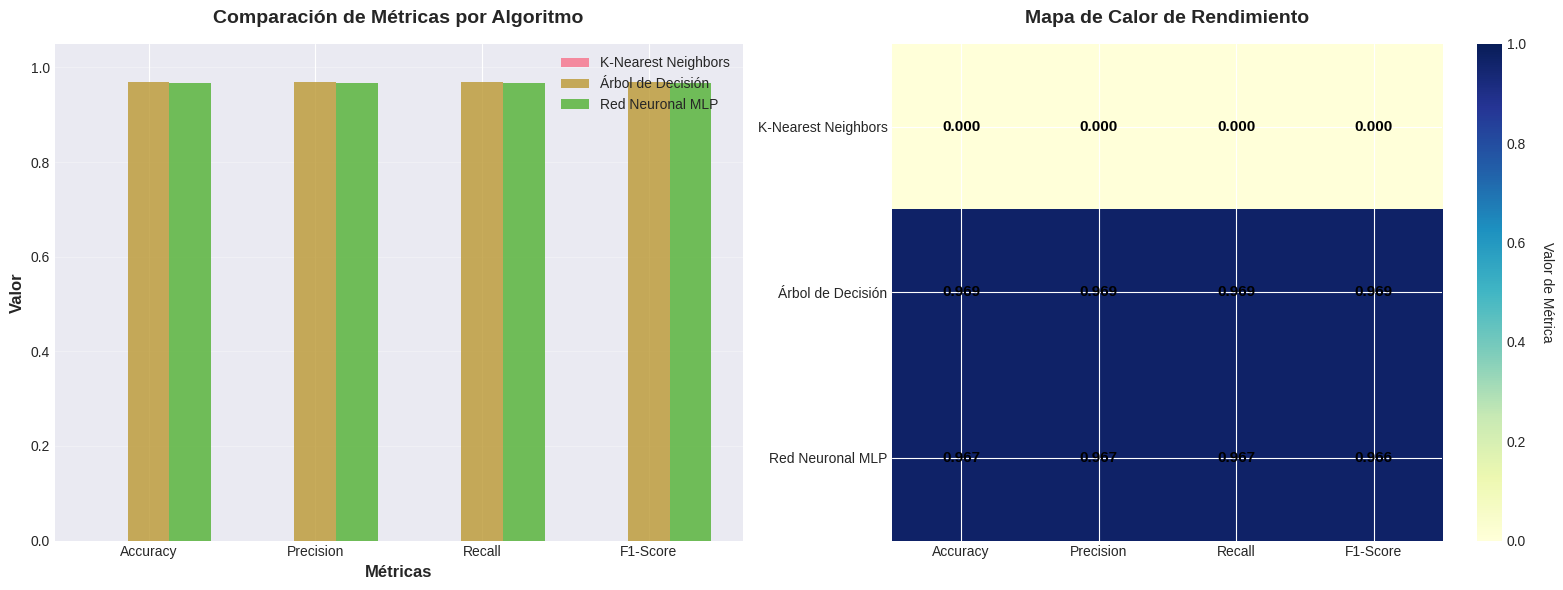


✅ Visualizaciones comparativas generadas


In [45]:
# Crear visualizaciones comparativas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Barras agrupadas por métrica
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

for i, algo in enumerate(comparison_df['Algoritmo']):
    values = comparison_df.iloc[i][metrics].values
    axes[0].bar(x + i*width, values, width, label=algo, alpha=0.8)

axes[0].set_xlabel('Métricas', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valor', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación de Métricas por Algoritmo', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Gráfico 2: Heatmap de métricas
metrics_matrix = comparison_df[metrics].values
im = axes[1].imshow(metrics_matrix, cmap='YlGnBu', aspect='auto', vmin=0, vmax=1)

# Añadir valores en cada celda
for i in range(len(comparison_df)):
    for j in range(len(metrics)):
        text = axes[1].text(j, i, f'{metrics_matrix[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=11, fontweight='bold')

axes[1].set_xticks(np.arange(len(metrics)))
axes[1].set_yticks(np.arange(len(comparison_df)))
axes[1].set_xticklabels(metrics)
axes[1].set_yticklabels(comparison_df['Algoritmo'])
axes[1].set_title('Mapa de Calor de Rendimiento', fontsize=14, fontweight='bold', pad=15)

# Añadir colorbar
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label('Valor de Métrica', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

print("\n✅ Visualizaciones comparativas generadas")

### 7.3. Análisis Cualitativo

In [46]:
print("=" * 80)
print("ANÁLISIS CUALITATIVO DE LOS ALGORITMOS")
print("=" * 80)

print("\n🔍 K-NEAREST NEIGHBORS (KNN):")
print("   Fortalezas:")
print("   • Simple y fácil de entender")
print("   • No requiere entrenamiento explícito")
print("   • Efectivo en espacios de baja dimensionalidad")
print("   Debilidades:")
print("   • Costoso en predicción (búsqueda de vecinos)")
print("   • Sensible a la escala de características")
print("   • Rendimiento se degrada con muchas dimensiones")

print("\n🌳 ÁRBOL DE DECISIÓN:")
print("   Fortalezas:")
print("   • Fácil de interpretar y visualizar")
print("   • No requiere normalización de datos")
print("   • Captura relaciones no lineales")
print("   • Puede manejar características mixtas")
print("   Debilidades:")
print("   • Propenso al sobreajuste sin poda")
print("   • Inestable ante pequeños cambios en datos")
print("   • Puede crear árboles muy complejos")

print("\n🧠 RED NEURONAL MLP:")
print("   Fortalezas:")
print("   • Aprende representaciones complejas y no lineales")
print("   • Excelente para datos multivariados")
print("   • Puede capturar patrones sutiles en señales")
print("   • Escalable a grandes volúmenes de datos")
print("   Debilidades:")
print("   • Requiere más tiempo de entrenamiento")
print("   • Difícil de interpretar ('caja negra')")
print("   • Necesita más datos para generalizar bien")
print("   • Requiere ajuste cuidadoso de hiperparámetros")

print("\n" + "=" * 80)
print("💡 RECOMENDACIONES:")
print("=" * 80)

best_algo = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Algoritmo']

print(f"\n✅ Para el dataset PAMAP2, se recomienda: {best_algo}")
print("\n📌 Justificación:")

if 'MLP' in best_algo or 'Neuronal' in best_algo:
    print("   • La red neuronal aprovecha mejor la naturaleza multivariada de los datos")
    print("   • Captura relaciones complejas entre sensores (mano, pecho, tobillo)")
    print("   • Maneja bien las 50+ características del dataset")
    print("   • Generaliza bien a nuevas actividades físicas")
elif 'Árbol' in best_algo:
    print("   • El árbol de decisión ofrece buena interpretabilidad")
    print("   • Puede identificar umbrales críticos en las señales")
    print("   • Balance entre rendimiento y simplicidad")
    print("   • Útil para entender qué características discriminan actividades")
else:
    print("   • KNN funciona bien cuando hay patrones claros en los datos")
    print("   • Efectivo con la normalización adecuada")
    print("   • Buen baseline para comparación")

print("\n🎯 Aplicaciones prácticas:")
print("   • Monitoreo de salud y fitness en tiempo real")
print("   • Asistencia a adultos mayores (detección de caídas)")
print("   • Optimización de entrenamientos deportivos")
print("   • Sistemas de vida asistida")

print("\n" + "=" * 80)

ANÁLISIS CUALITATIVO DE LOS ALGORITMOS

🔍 K-NEAREST NEIGHBORS (KNN):
   Fortalezas:
   • Simple y fácil de entender
   • No requiere entrenamiento explícito
   • Efectivo en espacios de baja dimensionalidad
   Debilidades:
   • Costoso en predicción (búsqueda de vecinos)
   • Sensible a la escala de características
   • Rendimiento se degrada con muchas dimensiones

🌳 ÁRBOL DE DECISIÓN:
   Fortalezas:
   • Fácil de interpretar y visualizar
   • No requiere normalización de datos
   • Captura relaciones no lineales
   • Puede manejar características mixtas
   Debilidades:
   • Propenso al sobreajuste sin poda
   • Inestable ante pequeños cambios en datos
   • Puede crear árboles muy complejos

🧠 RED NEURONAL MLP:
   Fortalezas:
   • Aprende representaciones complejas y no lineales
   • Excelente para datos multivariados
   • Puede capturar patrones sutiles en señales
   • Escalable a grandes volúmenes de datos
   Debilidades:
   • Requiere más tiempo de entrenamiento
   • Difícil de int